# Group Project of Datamining & Machine learning, fall semester 2020 : **Group Tissot**
*by Déborah Hernandez, François Grau and Simon Fellner*

Here is the evolution of our acccuracy on AIcrowd :

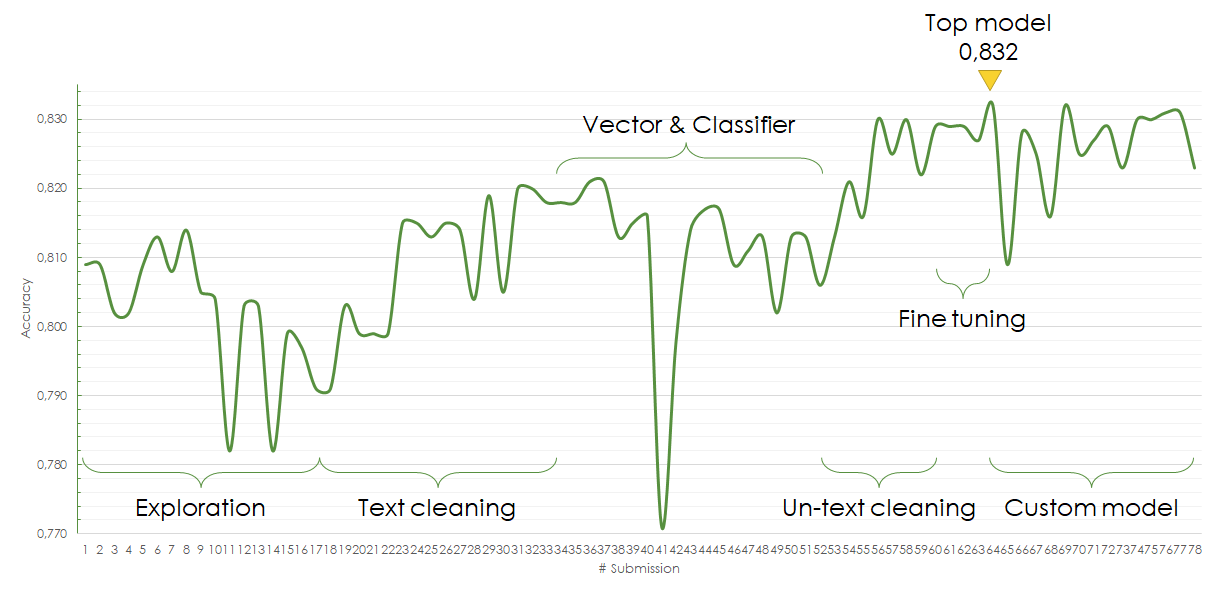

# 1. Initialisation

In [2]:
# Loading every module needed :
import numpy as np
import pandas as pd
import re 
import string
import matplotlib.pyplot as plt

from sklearn import datasets, tree
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from gensim.utils import simple_preprocess, lemmatize, deaccent
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument
import seaborn as sns

# Fixing the SEED value for random_seed property :
SEED = 72

In [3]:
# Allows to speed up a bit
import multiprocessing
cores = multiprocessing.cpu_count()

In [4]:
# Downloading the spacy module
!python -m spacy download en

# Import spacy 
import spacy

# Lorading english dictionnary
sp = spacy.load('en_core_web_sm')

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.6/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')


#2. Acquisition des données

In [5]:
# Reading the data transfered on our github :
Train = pd.read_csv('https://raw.githubusercontent.com/s-fellner/DMML2020_Tissot/main/data/Train_set.csv')
Test = pd.read_csv('https://raw.githubusercontent.com/s-fellner/DMML2020_Tissot/main/data/Test_set.csv')

# Replacing NaN values in the 'keyword' column :
print('NaN values in original sets :\n\n', '- Train dataset :\n',
      Train.isnull().sum(), '\n\n- Test dataset :\n', Test.isnull().sum(), 
      '\n\n-------------------------------------\n')
Test['keyword'].fillna('', inplace=True)
Train['keyword'].fillna('', inplace=True)
print('NaN values after replacement for "keyword" :\n\n', '- Train dataset :\n',
      Train.isnull().sum(), '\n\n- Test dataset :\n', Test.isnull().sum())

NaN values in original sets :

 - Train dataset :
 id             0
keyword       55
location    2141
text           0
target         0
dtype: int64 

- Test dataset :
 id            0
keyword       6
location    392
text          0
dtype: int64 

-------------------------------------

NaN values after replacement for "keyword" :

 - Train dataset :
 id             0
keyword        0
location    2141
text           0
target         0
dtype: int64 

- Test dataset :
 id            0
keyword       0
location    392
text          0
dtype: int64


In [6]:
# Building the dataset of features X (building of the model) and X_fin (predictions) by adding the keyword at the begining of the text :
X = Train['keyword'] + ' '  + Train['text']
X_fin = Test['keyword'] + ' ' + Test['text']

# Building the target dataset (building of the model)
y = Train['target'].astype('int')

X_fin

0       tsunami Crptotech tsunami and banks.\n http://...
1       traumatised I'm that traumatised that I can't ...
2       burning%20buildings @foxnewsvideo @AIIAmerican...
3       desolate Me watching Law &amp; Order (IB: @sau...
4               crushed Papi absolutely crushed that ball
                              ...                        
1137    derailed @ItsQueenBaby I'm at work it's a bunc...
1138    suicide%20bomber #?? #?? #??? #??? Suicide bom...
1139    volcano Eruption of Indonesian volcano sparks ...
1140    fear Never let fear get in the way of achievin...
1141    refugees wowo--=== 12000 Nigerian refugees rep...
Length: 1142, dtype: object

# 3. Text Cleaning

We tried to push the text cleaning really far by replacing special character, urls, mentions, hashtags, emojis and slang words. This task was completely manual (looking before / after cleaning and then generated tokens). But we observe that replacing slangs and hashtags reduced our accuracy (deleting # symbol or replacing #Word).

Improving accuracy by replacing :

*   'http\xxxxxxxx' by 'website'
*   @xxxx by 'user'
*   deleting digits
*   replacing emojis by the feeling associated to them (for example ':)' by 'happy')
*   deleting all special characters (for example '&' + 'amp;' is the encoding of '&')

Decreasing accuracy by replacing :

*   '#xxxxxx' by 'hashtag' or deleting only '#' or completely deleting it
*   slang words by their meaning (for example 'w/' by 'with')



In [7]:
# Replacing every special characters, urls, mentions, emojis of the feature (for X and X_fin) :
def cleaning(tweet):
  tweet = tweet.lower()

  tweet = re.sub(r'http\S+', ' website', tweet)
  tweet = re.sub(r'\S+\.com\S+', ' website', tweet)
  tweet = re.sub(r'\S+\.com\b', ' website', tweet)
  tweet = re.sub(r'@\S+', 'user', tweet)
  tweet = re.sub(r'@', ' ', tweet)

  tweet = re.sub(r'%20', ' ', tweet)
  tweet = re.sub(r'\x89ûï', '',tweet)  
  tweet = re.sub(r'\x89ûª', "'",tweet)
  tweet = re.sub(r'\x89û', '',tweet)
  tweet = re.sub(r'åê', ' ',tweet)
  # tweet = re.sub(r'w/','with ',tweet)
  tweet = re.sub(r'\x9d', ' ',tweet)
  #tweet = re.sub(r'#', 'hashtag ',tweet)
  tweet = re.sub(r'Ûª', "'",tweet)
  tweet = re.sub(r'\.\.\.', ' ', tweet)
  tweet = re.sub(r'\.\.', ' ', tweet)
  tweet = re.sub(r'\S+\Û_', ' ', tweet)
  tweet = re.sub(r'\brt\b', ' ', tweet)

  tweet = re.sub(r'-', ' ', tweet)

  tweet = re.sub('\d+', '', tweet)
  tweet = re.sub(r'&amp;', ' and ', tweet)
  tweet = re.sub(r'&lt;', 'and', tweet)
  
  tweet = re.sub(r'\s\:p', ' funny ', tweet)
  tweet = re.sub(r'\s\:\)', ' happy ', tweet)
  tweet = re.sub(r'\s\(\:', ' happy ', tweet)
  tweet = re.sub(r'\s\:s', ' annoyed ', tweet)
  tweet = re.sub(r'\s\:\(', ' sad ', tweet)
  tweet = re.sub(r'\s\)\:', ' sad ', tweet)
  tweet = re.sub(r'\s\/:', ' annoyed ', tweet)
  tweet = re.sub(r'\sxd', ' funny ', tweet)
  tweet = re.sub(r'\s=p', ' funny ', tweet)
  tweet = re.sub(r'\s\:\/', ' annoyed ', tweet)
  tweet = re.sub(r'\s\:o', ' surprised ', tweet)
  tweet = re.sub(r'\so\:', ' surprised ', tweet)
  tweet = re.sub(r'\sd\:', ' surprised ', tweet)

  tweet = re.sub(r'\x89û÷', '', tweet)
  tweet = re.sub(r'beû_', '', tweet)
  tweet = re.sub(r'\x89û_', '', tweet)
  tweet = re.sub(r'&gt', '', tweet)
  tweet = re.sub(r'\x89ûó', '', tweet)
  tweet = re.sub(r'\x89ûò', '', tweet)
  tweet = re.sub(r'\n', ' ', tweet)
  
  tweet = re.sub(r'÷', ' ', tweet)
  tweet = re.sub(r'ó', ' ', tweet)
  tweet = re.sub(r'ìü', ' ', tweet)
  tweet = re.sub(r'ìñ', ' ', tweet)
  tweet = re.sub(r'ì_', ' ', tweet)
  tweet = re.sub(r'_', ' ', tweet)

  # Old replacements : After test, those are decreasing accuracy 
  
  # tweet = re.sub(r'\byr\b', 'year', tweet)
  # tweet = re.sub(r'\bur\b', 'your', tweet)
  # tweet = re.sub(r'\blol\b', 'funny', tweet)
  # tweet = re.sub(r'\bomg\b', 'shocking', tweet)
  # tweet = re.sub(r'\bco\.', 'company', tweet)
  # tweet = re.sub(r"x'mas", 'christmas', tweet)
  # tweet = re.sub(r'\bvid\b', 'video', tweet)
  # tweet = re.sub(r"\bs'thing\b", 'something', tweet)
  # tweet = re.sub(r"\both\b", 'over the hill', tweet)
  # tweet = re.sub(r"\bde\b", 'of', tweet)
  # tweet = re.sub(r"\bnite\b", 'night', tweet)
  # tweet = re.sub(r"\brec\b", 'record', tweet)
  # tweet = re.sub(r"\bidc\b", "i don't care", tweet)
  # tweet = re.sub(r"\bthx\b", "thanks", tweet)
  # tweet = re.sub(r"\bmfs\b", 'insult', tweet)
  # tweet = re.sub(r"\bwtf\b", 'astonished', tweet)
  # tweet = re.sub(r"\bslsp\b", 'something', tweet)
  # tweet = re.sub(r"\bu\.s\.", 'united states', tweet)
  # tweet = re.sub(r"\ba\.m\.", 'morning', tweet)
  # tweet = re.sub(r"\bam\b", 'morning', tweet)
  # tweet = re.sub(r"\bpm\b", 'afternoon', tweet)
  # tweet = re.sub(r"\bokay\b", 'ok', tweet)
  # tweet = re.sub(r"\betc\.", 'and so forth', tweet)
  # tweet = re.sub(r"\bdept\.", 'department', tweet)
  # tweet = re.sub(r"\bwut\b", 'what', tweet)
  # tweet = re.sub(r"\bpls\b", 'please', tweet)
  # tweet = re.sub(r"\blmao\b", 'funny', tweet)
  # tweet = re.sub(r"\bhaha\b", 'funny', tweet)
  # tweet = re.sub(r"\benroute\b", 'on the way', tweet)
  # tweet = re.sub(r"\bgov\.", 'government', tweet)
  # tweet = re.sub(r"\bdr\.", 'doctor', tweet)
  # tweet = re.sub(r"\bkindof\b", 'kind of', tweet)
  # tweet = re.sub(r"\bppl\b", 'people', tweet)
  # tweet = re.sub(r"\bu\b", 'you', tweet)

  return tweet

In [8]:
# Random seed for samples
sss = 57
# Tweets before cleaning
a = X.sample(20, random_state=sss).values
print(a)
print('-----------------------------------------------')

# Cleaning the tweets
X = X.apply(lambda x : cleaning(x))
X_fin = X_fin.apply(lambda x : cleaning(x))

# Tweets after cleaning
a = X.sample(20, random_state=sss).values
print(a)

["eyewitness @kaputt21 Hamburg Police Chief Gregory Wickett has told 7 Eyewitness News he 'can't confirm or deny' an investigation is underway."
 'wild%20fires @randerson62 Watching news of wild fires and hope all is ok.'
 'arson Arson suspect linked to 30 fires caught in Northern California http://t.co/u1fuWrGK5U'
 'blizzard @StevenOnTwatter @PussyxDestroyer just order a blizzard pay then put your nuts in it say they have you ball flavored. Boom free ice cream'
 "screaming MY FAVS I'M SCREAMING SO FUCKING LOUD http://t.co/cP7c1cH0ZU"
 ' Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school '
 "injured @chikislizeth08 you're not injured anymore? ??"
 "quarantined Reddit's new content policy goes into effect many horrible subreddits banned or quarantined http://t.co/4oNvxncz8w http://t.co/tnggXNm6k8"
 "bioterrorism @O_Magazine satan's daughter shadow warrior in 50ft women aka transgender mode ps nyc is about to fold extra extra center of bioterrorism"
 

# 4. Exploratory Data Analysis

## 4.1. Base Rate
We tried to rebalance the Train dataset by deleting entries to rebalance the br to 0.5, but then the model is less efficient.

In [9]:
# Calculing the base rate of the dataset :
def br_calc(target_col):
  classes = {}
  for target in target_col:
    if target not in classes:
      classes[target] = 1
    else:
      classes[target] += 1
  br = max(classes.values())/sum(classes.values())
  return br

print('The base rate for target is', round(br_calc(Train['target']), 2))

# # Create balanced dataframe - base rate = 0.5
# Train_bal = pd.concat([Train[Train["target"] == 0].sample(len(Train[Train["target"] == 1])), Train[Train["target"] == 1]], axis=0).reset_index()
# Train = Train_bal
# print(Train)

# print('The base rate for target is', round(br_calc(Train['target']), 2))

The base rate for target is 0.57


## 4.2. Adding features to datas
For EDA and maybe improving model

In [10]:
# Counting specificities of a sentence
def counterize(df):

  word = []
  mention = []
  hashtag = []
  capital = []
  question = []
  url = []
  emoji = []
  emojis_list = [
  r'\s\:\)',
  r'\s\:\(',
  r'\s\(\:',
  r'\s\)\:',
  r'\s\:\/',
  r'\s\:D\b',
  r'\sO\:',
  r'\sD\:',
  r'\so\:',
  r'\s\:O\b',
  r'\s\:o\b',
  r'\s\:\|',
  r'\s\:p\b',
  r'\s\:P\b',
  r'\sxD\b',
  r'\sx\)',
  r'\sx\(',
  r'\s\(x\b',
  r'\s=P\b',
  r'\sXD\b',
  r'\sxd\b'        
  ]

  x=0
  while x < df.shape[0]:
    word.append(len(re.findall(r'\w+', df['text'][x])))
    mention.append(len(re.findall(r'@\w+', df['text'][x])))
    hashtag.append(len(re.findall(r'#\w+', df['text'][x])))
    capital.append(len(re.findall(r'\b[A-Z]', df['text'][x])))
    question.append(len(re.findall(r'!|\?', df['text'][x])))
    url.append(len(re.findall(r'http.?://[^\s]+[\s]?', df['text'][x])))
    mogs = 0
    for mog in emojis_list:
      mogs += len(re.findall(mog, df['text'][x]))
    emoji.append(mogs)
    x+=1

  df['word'] = word
  df['mention'] = mention
  df['hashtag'] = hashtag
  df['capital'] = capital
  df['question'] = question
  df['url'] = url
  df['emoji'] = emoji

In [110]:
# Adding features to Train and Test
counterize(Train)
counterize(Test)

Train

,id,keyword,location,text,target,word,mention,hashtag,capital,question,url,emoji
0,3738,destroyed,USA,Black Eye 9: A space battle occurred at Star O...,0,19,0,0,5,0,0,0
1,853,bioterror,NaN,#world FedEx no longer to transport bioterror ...,0,18,0,1,1,0,1,0
2,10540,windstorm,"Palm Beach County, FL",Reality Training: Train falls off elevated tra...,1,15,0,2,6,0,1,0
3,5988,hazardous,USA,#Taiwan Grace: expect that large rocks trees m...,1,21,0,1,2,0,0,0
4,6328,hostage,Australia,New ISIS Video: ISIS Threatens to Behead Croat...,1,19,0,1,12,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
6466,4377,earthquake,ARGENTINA,#Earthquake #Sismo M 1.9 - 15km E of Anchorage...,1,28,0,2,9,0,1,0
6467,3408,derail,NaN,@EmiiliexIrwin Totally agree.She is 23 and kno...,0,27,1,0,4,0,0,0
6468,9794,trapped,NaN,Hollywood Movie About Trapped Miners Released ...,1,20,0,0,9,0,1,0
6469,10344,weapons,Beirut/Toronto,Friendly reminder that the only country to eve...,1,24,0,0,4,0,1,0


In [40]:
# Keeping dataframe with target = 0 and target = 1
Train_0 = Train[Train['target'] == 0]
Train_1 = Train[Train['target'] == 1]

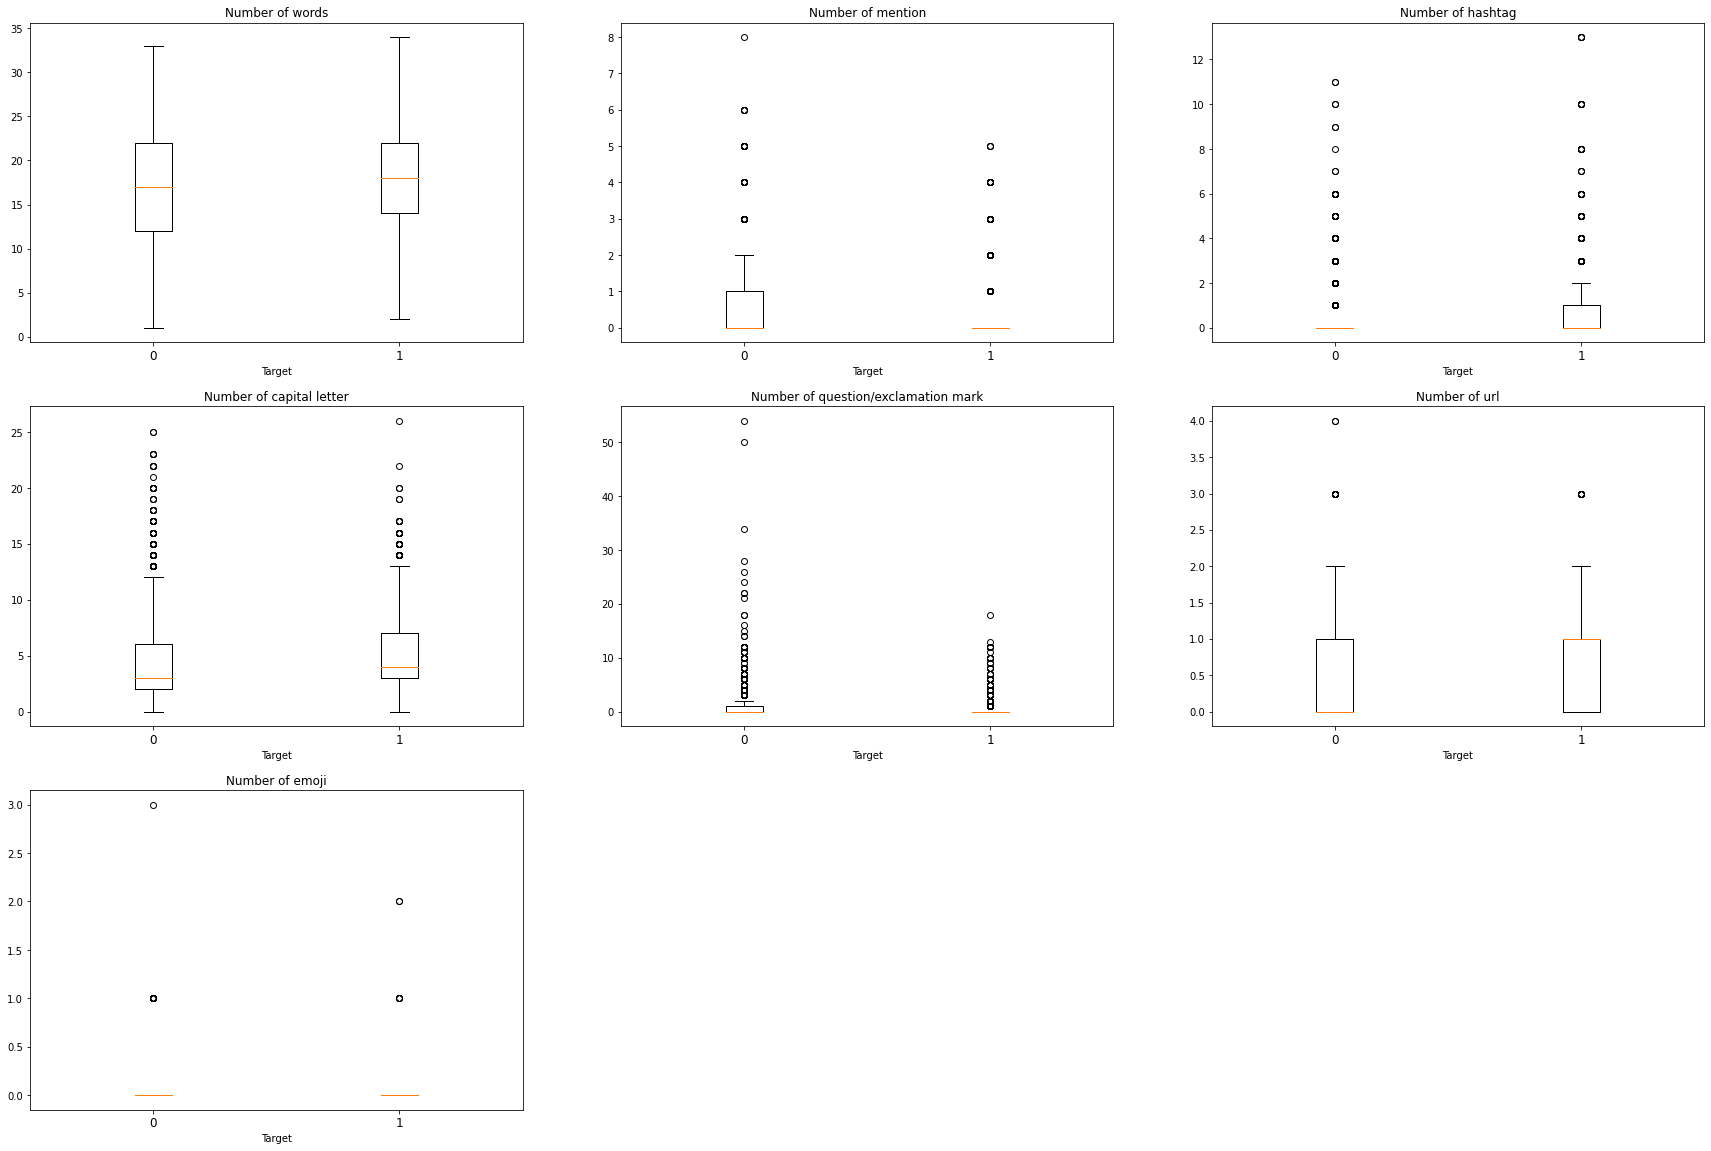

In [65]:
# Boxplotting additional features per class
fig, ax = plt.subplots(3,3, figsize=(30,20))
ax[0,0].boxplot([Train_0['word'], Train_1['word']])
ax[0,0].set_title('Number of words')
ax[0,0].set_xticklabels([0,1], fontsize=12)
ax[0,0].set_xlabel('Target')

ax[0,1].boxplot([Train_0['mention'], Train_1['mention']])
ax[0,1].set_title('Number of mention')
ax[0,1].set_xticklabels([0,1], fontsize=12)
ax[0,1].set_xlabel('Target')

ax[0,2].boxplot([Train_0['hashtag'], Train_1['hashtag']])
ax[0,2].set_title('Number of hashtag')
ax[0,2].set_xticklabels([0,1], fontsize=12)
ax[0,2].set_xlabel('Target')

ax[1,0].boxplot([Train_0['capital'], Train_1['capital']])
ax[1,0].set_title('Number of capital letter')
ax[1,0].set_xticklabels([0,1], fontsize=12)
ax[1,0].set_xlabel('Target')

ax[1,1].boxplot([Train_0['question'], Train_1['question']])
ax[1,1].set_title('Number of question/exclamation mark')
ax[1,1].set_xticklabels([0,1], fontsize=12)
ax[1,1].set_xlabel('Target')

ax[1,2].boxplot([Train_0['url'], Train_1['url']])
ax[1,2].set_title('Number of url')
ax[1,2].set_xticklabels([0,1], fontsize=12)
ax[1,2].set_xlabel('Target')

ax[2,0].boxplot([Train_0['emoji'], Train_1['emoji']])
ax[2,0].set_title('Number of emoji')
ax[2,0].set_xticklabels([0,1], fontsize=12)
ax[2,0].set_xlabel('Target')

fig.delaxes(ax[2,1])
fig.delaxes(ax[2,2])
plt.draw()

We can deduce that the additionnal features 'hashtag', 'mention' and 'question' are interesting to use.

In [111]:
# Saving those feature in specifics variables
Train_add = Train[['mention', 'hashtag', 'question']]
Test_add = Test[['mention','hashtag', 'question']]

# Setting scaler
scaler = preprocessing.StandardScaler()

# Normalise columns
Train_add = pd.DataFrame(scaler.fit_transform(Train_add))
Test_add = pd.DataFrame(scaler.transform(Test_add))

Test_add

,0,1,2
0,-0.504068,3.256630,-0.295690
1,-0.504068,-0.399768,0.741952
2,3.654653,-0.399768,4.892519
3,2.268413,-0.399768,-0.295690
4,-0.504068,-0.399768,-0.295690
...,...,...,...
1137,0.882172,-0.399768,-0.295690
1138,-0.504068,-0.399768,4.892519
1139,-0.504068,-0.399768,0.223131
1140,-0.504068,4.170729,0.223131


## 4.3. Building dicts for Train, Train target = 0, Train target = 1 and Test

In [13]:
# Building a dictionnary of contained words and the number of appearence
stop_words = spacy.lang.en.stop_words.STOP_WORDS
punctuations = string.punctuation

def dictio(df, clean=False):
  dict = {}
  for tweet in df:
    if clean:
      tweet = cleaning(tweet)
    text = simple_preprocess(tweet)
    for word in text:
      if word not in stop_words:
        if word not in dict:
          dict[word] = 1
        else:
          dict[word] +=1
  return dict

In [14]:
# Building dictionnaries

# of normal tweets 
dict_0 = dictio(Train_0['text'])
dict_1 = dictio(Train_1['text'])

# of cleaned tweets
dict_0_cl = dictio(Train_0['text'], True)
dict_1_cl = dictio(Train_1['text'], True)

In [30]:
# Convert a dic in df
from collections import OrderedDict

def dic_framing(dict, qty, reverse=False):

  dic = OrderedDict(sorted(dict.items(), key=lambda t: t[1], reverse=reverse))

  top_w = pd.DataFrame()

  words = []
  numbers = []
  x=0
  for word in dic:
    words.append(word)
    numbers.append(dic[word])
    x+=1
    if x==qty:
      break
  
  top_w['word'] = words
  top_w['number'] = numbers

  return top_w

# top 10 words of original tweets
top_0 = dic_framing(dict_0, 30, True)
top_1 = dic_framing(dict_1, 30, True)

# top 10 words of clean tweets
top_0_cl = dic_framing(dict_0_cl, 30, True)
top_1_cl = dic_framing(dict_1_cl, 30, True)

# Dropping the 2 first top words (website components)
top_0.drop(top_0.index[:2], inplace=True)
top_1.drop(top_1.index[:2], inplace=True)
top_0_cl.drop(top_0_cl.index[:2], inplace=True)
top_1_cl.drop(top_1_cl.index[:2], inplace=True)

## 4.4. EDA

Text(0.5, 1.0, 'Word appearence in cleaned text : Target = 1')

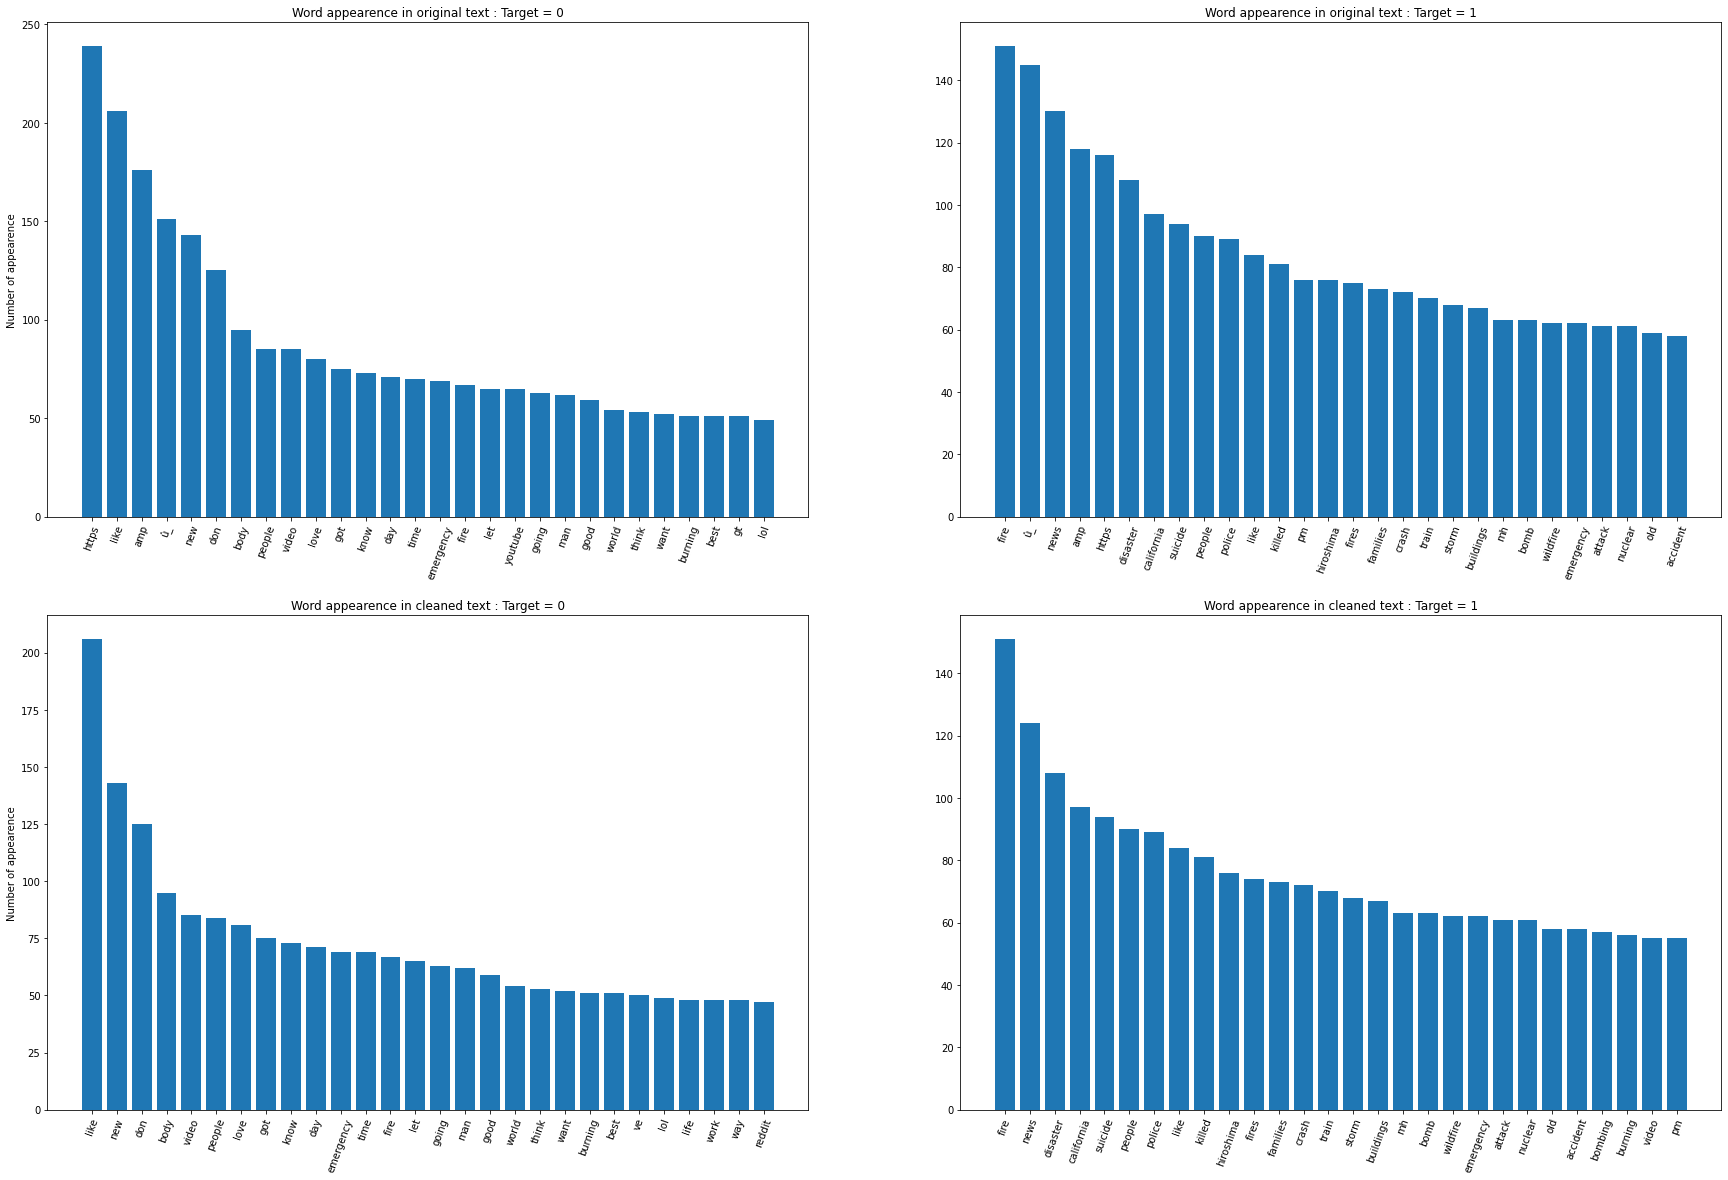

In [37]:
# plotting Top words per class
fig, ax = plt.subplots(2,2, figsize=(30,20))
ax[0,0].bar(top_0['word'], top_0['number'])
ax[0,1].bar(top_1['word'], top_1['number'])
ax[1,0].bar(top_0_cl['word'], top_0_cl['number'])
ax[1,1].bar(top_1_cl['word'], top_1_cl['number'])

ax[0,0].tick_params('x', labelrotation=70)
ax[0,1].tick_params('x', labelrotation=70)
ax[1,0].tick_params('x', labelrotation=70)
ax[1,1].tick_params('x', labelrotation=70)

ax[0,0].set_ylabel('Number of appearence')
ax[1,0].set_ylabel('Number of appearence')

ax[0,0].set_title('Word appearence in original text : Target = 0')
ax[0,1].set_title('Word appearence in original text : Target = 1')
ax[1,0].set_title('Word appearence in cleaned text : Target = 0')
ax[1,1].set_title('Word appearence in cleaned text : Target = 1')

# 5. Tokenizer
We tried to build our own tokenizer. But we observed that the gensim.simple_preprocess performed better in the model.

In [ ]:
# Cleaned features before tokenization :
spl = X.sample(20, random_state=sss)
display(spl.values)

# Tokenized clean features :
for x in spl:
  print(simple_preprocess(x))

array(["eyewitness user hamburg police chief gregory wickett has told  eyewitness news he 'can't confirm or deny' an investigation is underway.",
       'wild fires user watching news of wild fires and hope all is ok.',
       'arson arson suspect linked to  fires caught in northern california  website',
       'blizzard user user just order a blizzard pay then put your nuts in it say they have you ball flavored. boom free ice cream',
       "screaming my favs i'm screaming so fucking loud  website",
       ' just got sent this photo from ruby #alaska as smoke from #wildfires pours into a school ',
       "injured user you're not injured anymore? ??",
       "quarantined reddit's new content policy goes into effect many horrible subreddits banned or quarantined  website  website",
       "bioterrorism user satan's daughter shadow warrior in ft women aka transgender mode ps nyc is about to fold extra extra center of bioterrorism",
       'injured  dead dozens injured in gaza blast near 

['eyewitness', 'user', 'hamburg', 'police', 'chief', 'gregory', 'wickett', 'has', 'told', 'eyewitness', 'news', 'he', 'can', 'confirm', 'or', 'deny', 'an', 'investigation', 'is', 'underway']
['wild', 'fires', 'user', 'watching', 'news', 'of', 'wild', 'fires', 'and', 'hope', 'all', 'is', 'ok']
['arson', 'arson', 'suspect', 'linked', 'to', 'fires', 'caught', 'in', 'northern', 'california', 'website']
['blizzard', 'user', 'user', 'just', 'order', 'blizzard', 'pay', 'then', 'put', 'your', 'nuts', 'in', 'it', 'say', 'they', 'have', 'you', 'ball', 'flavored', 'boom', 'free', 'ice', 'cream']
['screaming', 'my', 'favs', 'screaming', 'so', 'fucking', 'loud', 'website']
['just', 'got', 'sent', 'this', 'photo', 'from', 'ruby', 'alaska', 'as', 'smoke', 'from', 'wildfires', 'pours', 'into', 'school']
['injured', 'user', 'you', 're', 'not', 'injured', 'anymore']
['quarantined', 'reddit', 'new', 'content', 'policy', 'goes', 'into', 'effect', 'many', 'horrible', 'subreddits', 'banned', 'or', 'quaranti

# 6. Optimisation
The goal of this step is to find the best vector and the best classifier : with maximal accuracy on validation set (accuracy of a set which was not used in the building of the model) by spliting X and y in X_train, X_test (validation), y_train, y_test (validation)

## 6.1. (BEST MODEL) LogReg ---------- MAX ACCURACY = 0.8147
Vector : TFIDF
* n_gram : (1, 1)
* min_df : 3
* max_df : 1.0
* analyzer : 'word'
* sublinear_tf : True
* norm : 'l2'

Classifier parameters :

*   C : 1.21

VALIDATION ACCURACY = 0.8147

REAL ACCURACY = 0.832

#### 6.1.1. LogReg TFIDF ---------- MAX ACCURACY = 0.8147 

In [ ]:
# Create list of configs
def configs():

    models = list()
    
    # Define config lists
    ngram_range = [(1,1)] #0  [(1,1), (1,2), (1,3), (2,2), (2,3), (3,3)]
    min_df = [3] #1 [0, 1, 2, 3, 4, 5]
    max_df = [1.0] #2 [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
    analyzer=['word'] #3  ['word', 'char']
    sublinear_tf = [True] #4  [True, False]
    norm = ['l2'] #5  ['l1', 'l2']
    C = [1.3738237958832638] #6 np.logspace(-4, 4, 20)


    
    # Create config instances
    for n in ngram_range:
        for i in min_df:
            for j in max_df:
              for a in analyzer:
                for s in sublinear_tf:
                  for no in norm:
                    for c in C:
                      cfg = [n, i, j, a, s, no, c]
                      models.append(cfg)
    return models

configs = configs()
print(configs)
print(len(configs))

[[(1, 1), 3, 1.0, 'word', True, 'l2', 1.3738237958832638], [(1, 1), 3, 1.0, 'word', False, 'l2', 1.3738237958832638]]
2


**TO BEAT :**

(1, 1), 3, 1.0, 'word', True, 'l2', 1.3738237958832638
ACCURACY SCORE = 0.8146718146718147 


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)
    
# Define list for result
result = []

for config in configs:

  # Redefine vectorizer
  tfidf_vector = TfidfVectorizer(tokenizer=simple_preprocess, 
                                ngram_range=config[0],
                                min_df=config[1],
                                 max_df=config[2], 
                                 analyzer=config[3], 
                                 sublinear_tf=config[4], 
                                 norm=config[5], 
                                 encoding='latin-1')

  # Define classifier
  classifier = LogisticRegression(C=config[6], max_iter=1000, n_jobs=cores, random_state=SEED, solver='lbfgs')

  # Create pipeline
  pipe = Pipeline([('vectorizer', tfidf_vector), ('classifier', classifier)])

  # Fit model on training set
  pipe.fit(X_train, y_train)

  # Predictions
  y_pred = pipe.predict(X_test)

  # Print accuracy on test set
  print("CONFIG: ", config)
  print(f"TEST ACCURACY SCORE:\n{accuracy_score(y_test, y_pred):.4f}")
  print(f"TEST F1 SCORE:\n{f1_score(y_test, y_pred):.4f}")
  print(f"TEST CONFUSION MATRIX:\n{confusion_matrix(y_test, y_pred)}")
  print("-----------------------")

  # Append to result
  result.append([config, accuracy_score(y_test, y_pred)])

result.sort(key=lambda x:x[1])
print('Top parameters :\n')
print(result[-1])

CONFIG:  [(1, 1), 3, 1.0, 'word', True, 'l2', 1.3738237958832638]
TEST ACCURACY SCORE:
0.8147
TEST F1 SCORE:
0.7683
TEST CONFUSION MATRIX:
[[657  90]
 [150 398]]
-----------------------
CONFIG:  [(1, 1), 3, 1.0, 'word', False, 'l2', 1.3738237958832638]
TEST ACCURACY SCORE:
0.8093
TEST F1 SCORE:
0.7618
TEST CONFUSION MATRIX:
[[653  94]
 [153 395]]
-----------------------
Top parameters :

[[(1, 1), 3, 1.0, 'word', True, 'l2', 1.3738237958832638], 0.8146718146718147]


#### 6.1.2. LogReg CountVector ---------- MAX ACCURACY = 0.8008

In [ ]:
# Create list of configs
def configs():

    models = list()
    
    # Define config lists
    ngram_range = [(1,3)] #0  [(1,1), (1,2), (1,3), (2,2), (2,3), (3,3)]
    min_df = [2] #1 [0, 1, 2, 3, 4, 5]
    max_df = [0.5] #2 [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
    analyzer=['word'] #3  ['word', 'char', 'char_wb']
    C = [0.08858667904100823] #4 np.logspace(-4, 4, 20)


    
    # Create config instances
    for a in ngram_range:
      for b in min_df:
        for c in max_df:
          for d in analyzer:
            for e in C:
              cfg = [a, b, c, d, e]
              models.append(cfg)
    return models

configs = configs()
print(configs)
print(len(configs))

[[(1, 1), 1, 1.0, 'word', 1.4]]
1


**TO BEAT :**

(1, 3), 2, 0.5, 'word', 0.08858667904100823
ACCURACY SCORE = 0.8007722007722008

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)
    
# Define list for result
result = []

for config in configs:

  # Redefine vectorizer
  tfidf_vector = CountVectorizer(tokenizer=simple_preprocess, 
                                ngram_range=config[0],
                                min_df=config[1],
                                max_df=config[2], 
                                analyzer=config[3], 
                                encoding='latin-1')

  # Define classifier
  classifier = LogisticRegression(C=config[4], max_iter=1000, n_jobs=cores, random_state=SEED, solver='lbfgs')

  # Create pipeline
  pipe = Pipeline([('vectorizer', tfidf_vector), ('classifier', classifier)])

  # Fit model on training set
  pipe.fit(X_train, y_train)

  # Predictions
  y_pred = pipe.predict(X_test)

  # Print accuracy on test set
  print("CONFIG: ", config)
  print(f"TEST ACCURACY SCORE:\n{accuracy_score(y_test, y_pred):.4f}")
  print(f"TEST F1 SCORE:\n{f1_score(y_test, y_pred):.4f}")
  print(f"TEST CONFUSION MATRIX:\n{confusion_matrix(y_test, y_pred)}")
  print("-----------------------")

  # Append to result
  result.append([config, accuracy_score(y_test, y_pred)])

result.sort(key=lambda x:x[1])
print('Top parameters :\n')
print(result[-1])

CONFIG:  [(1, 1), 1, 1.0, 'word', 1.4]
TEST ACCURACY SCORE:
0.7792
TEST F1 SCORE:
0.7342
TEST CONFUSION MATRIX:
[[614 133]
 [153 395]]
-----------------------
Top parameters :

[[(1, 1), 1, 1.0, 'word', 1.4], 0.7791505791505792]


## 6.2. Decision Tree ---------- MAX ACCURACY = 0.7598

Vector : TFIDF


* n_gram : (1, 2)
* min_df : 0
* max_df : 1.0
* analyzer : 'word'
* sublinear_tf : False
* norm : 'l2'

Classifier parameters :

*   criterion : 'entropy'
*   splitter : 'random'
*   max_depth : None
*   min_impurity_decrease : 0.0
*   min_impurity_split : 0.2
*   min_samples_leaf : 2
*   max_leaf_nodes : None
*   max_features : 'auto'

### 6.2.1. Decision Tree TFIDF ---------- MAX ACCURACY = 0.7598

In [ ]:
# Create list of configs
def configs():

    models = list()
    
    # Define config lists
    ngram_range = [(1,2)] #0  [(1,1), (1,2), (1,3), (2,2), (2,3), (3,3)]
    
    min_df = [0] #1 [0, 1, 2, 3, 4, 5]
    max_df = [1.0] #2 [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
    
    analyzer=['word'] #3  ['word', 'char']
    sublinear_tf = [True, False] #4  [True, False]
    norm = ['l2'] #5  ['l1', 'l2']

    crit = ['entropy'] #6 ['gini', 'entropy']
    split = ['random'] #7 ['best', 'random']
    
    maxdep = [None] #8 [10, 50, 100, 200, 500, 1000, None]

    minimpd = [0.0] #9 [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]
    minimps = [0.2] #10 [None, 0.05, 0.1, 0.15, 0.2]
    minspl = [2] #11 [1, 2, 3, 4, 5]
    maxleaf = [None] #12 [None, 2, 3, 4, 5]
    
    maxfeat = ['auto'] #13 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25, 30, 35, 40, 45, 50, 'auto']


    
    # Create config instances
    for a in ngram_range:
      for b in min_df:
        for c in max_df:
          for d in analyzer:
            for e in sublinear_tf:
              for f in norm:
                for g in crit:
                  for h in split:
                    for i in maxdep:
                      for j in minimpd:
                        for k in minimps:
                          for l in minspl:
                            for m in maxleaf:
                              for n in maxfeat:
                                cfg = [a, b, c, d, e, f, g, h, i, j, k, l, m, n]
                                models.append(cfg)
    return models

configs = configs()
print(configs)
print(len(configs))

[[(1, 2), 0, 1.0, 'word', True, 'l2', 'entropy', 'random', None, 0.0, 0.2, 2, None, 1], [(1, 2), 0, 1.0, 'word', True, 'l2', 'entropy', 'random', None, 0.0, 0.2, 2, None, 2], [(1, 2), 0, 1.0, 'word', True, 'l2', 'entropy', 'random', None, 0.0, 0.2, 2, None, 3], [(1, 2), 0, 1.0, 'word', True, 'l2', 'entropy', 'random', None, 0.0, 0.2, 2, None, 4], [(1, 2), 0, 1.0, 'word', True, 'l2', 'entropy', 'random', None, 0.0, 0.2, 2, None, 5], [(1, 2), 0, 1.0, 'word', True, 'l2', 'entropy', 'random', None, 0.0, 0.2, 2, None, 6], [(1, 2), 0, 1.0, 'word', True, 'l2', 'entropy', 'random', None, 0.0, 0.2, 2, None, 7], [(1, 2), 0, 1.0, 'word', True, 'l2', 'entropy', 'random', None, 0.0, 0.2, 2, None, 8], [(1, 2), 0, 1.0, 'word', True, 'l2', 'entropy', 'random', None, 0.0, 0.2, 2, None, 9], [(1, 2), 0, 1.0, 'word', True, 'l2', 'entropy', 'random', None, 0.0, 0.2, 2, None, 10], [(1, 2), 0, 1.0, 'word', True, 'l2', 'entropy', 'random', None, 0.0, 0.2, 2, None, 15], [(1, 2), 0, 1.0, 'word', True, 'l2', 'en

**TO BEAT :**

[[(1, 2), 0, 1.0, 'word', False, 'l2', 'entropy', 'random', None, 0.0, 0.2, 2, None, 'auto'], 0.7598455598455598, 0.6797116374871266] 

[[(1, 2), 0, 1.0, 'word', True, 'l2', 'entropy', 'random', None, 0.0, 0.05, 1, None, 'auto'], 0.7498069498069498, 0.6823529411764706]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)
    
# Define list for result
result = []

for config in configs:

  # Redefine vectorizer
  tfidf_vector = TfidfVectorizer(tokenizer=simple_preprocess, 
                                ngram_range=config[0],
                                min_df=config[1],
                                 max_df=config[2], 
                                 analyzer=config[3], 
                                 sublinear_tf=config[4], 
                                 norm=config[5], 
                                 encoding='latin-1')

  # Define classifier
  classifier = tree.DecisionTreeClassifier(criterion=config[6], splitter=config[7], max_depth=config[8], min_impurity_decrease=config[9],
                                           min_impurity_split=config[10], min_samples_leaf=config[11], max_leaf_nodes=config[12], max_features=config[13],
                                           random_state=SEED)

  # Create pipeline
  pipe = Pipeline([('vectorizer', tfidf_vector), ('classifier', classifier)])

  # Fit model on training set
  pipe.fit(X_train, y_train)

  # Predictions
  y_pred = pipe.predict(X_test)

  # Print accuracy on test set
  print("CONFIG: ", config)
  print(f"TEST ACCURACY SCORE:\n{accuracy_score(y_test, y_pred):.4f}")
  print(f"TEST F1 SCORE:\n{f1_score(y_test, y_pred):.4f}")
  print(f"TEST CONFUSION MATRIX:\n{confusion_matrix(y_test, y_pred)}")
  print("-----------------------")

  # Append to result
  result.append([config, accuracy_score(y_test, y_pred), f1_score(y_test, y_pred)])

result.sort(key=lambda x:x[1])
print('Top parameters (accuracy) :\n')
print(result[-1], '\n')
result.sort(key=lambda x:x[2])
print('Top parameters (F1) :\n')
print(result[-1])

/usr/local/lib/python3.6/dist-packages/sklearn/tree/_classes.py:301: FutureWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


CONFIG:  [(1, 2), 0, 1.0, 'word', True, 'l2', 'entropy', 'random', None, 0.0, 0.2, 2, None, 1]
TEST ACCURACY SCORE:
0.5768
TEST F1 SCORE:
0.0000
TEST CONFUSION MATRIX:
[[747   0]
 [548   0]]
-----------------------


/usr/local/lib/python3.6/dist-packages/sklearn/tree/_classes.py:301: FutureWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


CONFIG:  [(1, 2), 0, 1.0, 'word', True, 'l2', 'entropy', 'random', None, 0.0, 0.2, 2, None, 2]
TEST ACCURACY SCORE:
0.5768
TEST F1 SCORE:
0.0000
TEST CONFUSION MATRIX:
[[747   0]
 [548   0]]
-----------------------


/usr/local/lib/python3.6/dist-packages/sklearn/tree/_classes.py:301: FutureWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


CONFIG:  [(1, 2), 0, 1.0, 'word', True, 'l2', 'entropy', 'random', None, 0.0, 0.2, 2, None, 3]
TEST ACCURACY SCORE:
0.5768
TEST F1 SCORE:
0.0000
TEST CONFUSION MATRIX:
[[747   0]
 [548   0]]
-----------------------


/usr/local/lib/python3.6/dist-packages/sklearn/tree/_classes.py:301: FutureWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


CONFIG:  [(1, 2), 0, 1.0, 'word', True, 'l2', 'entropy', 'random', None, 0.0, 0.2, 2, None, 4]
TEST ACCURACY SCORE:
0.5768
TEST F1 SCORE:
0.0000
TEST CONFUSION MATRIX:
[[747   0]
 [548   0]]
-----------------------


/usr/local/lib/python3.6/dist-packages/sklearn/tree/_classes.py:301: FutureWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


CONFIG:  [(1, 2), 0, 1.0, 'word', True, 'l2', 'entropy', 'random', None, 0.0, 0.2, 2, None, 5]
TEST ACCURACY SCORE:
0.5768
TEST F1 SCORE:
0.0000
TEST CONFUSION MATRIX:
[[747   0]
 [548   0]]
-----------------------


/usr/local/lib/python3.6/dist-packages/sklearn/tree/_classes.py:301: FutureWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


CONFIG:  [(1, 2), 0, 1.0, 'word', True, 'l2', 'entropy', 'random', None, 0.0, 0.2, 2, None, 6]
TEST ACCURACY SCORE:
0.5768
TEST F1 SCORE:
0.0000
TEST CONFUSION MATRIX:
[[747   0]
 [548   0]]
-----------------------


/usr/local/lib/python3.6/dist-packages/sklearn/tree/_classes.py:301: FutureWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


CONFIG:  [(1, 2), 0, 1.0, 'word', True, 'l2', 'entropy', 'random', None, 0.0, 0.2, 2, None, 7]
TEST ACCURACY SCORE:
0.5768
TEST F1 SCORE:
0.0000
TEST CONFUSION MATRIX:
[[747   0]
 [548   0]]
-----------------------


/usr/local/lib/python3.6/dist-packages/sklearn/tree/_classes.py:301: FutureWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


CONFIG:  [(1, 2), 0, 1.0, 'word', True, 'l2', 'entropy', 'random', None, 0.0, 0.2, 2, None, 8]
TEST ACCURACY SCORE:
0.5768
TEST F1 SCORE:
0.0000
TEST CONFUSION MATRIX:
[[747   0]
 [548   0]]
-----------------------


/usr/local/lib/python3.6/dist-packages/sklearn/tree/_classes.py:301: FutureWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


CONFIG:  [(1, 2), 0, 1.0, 'word', True, 'l2', 'entropy', 'random', None, 0.0, 0.2, 2, None, 9]
TEST ACCURACY SCORE:
0.5768
TEST F1 SCORE:
0.0000
TEST CONFUSION MATRIX:
[[747   0]
 [548   0]]
-----------------------


/usr/local/lib/python3.6/dist-packages/sklearn/tree/_classes.py:301: FutureWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


CONFIG:  [(1, 2), 0, 1.0, 'word', True, 'l2', 'entropy', 'random', None, 0.0, 0.2, 2, None, 10]
TEST ACCURACY SCORE:
0.5807
TEST F1 SCORE:
0.0286
TEST CONFUSION MATRIX:
[[744   3]
 [540   8]]
-----------------------


/usr/local/lib/python3.6/dist-packages/sklearn/tree/_classes.py:301: FutureWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


CONFIG:  [(1, 2), 0, 1.0, 'word', True, 'l2', 'entropy', 'random', None, 0.0, 0.2, 2, None, 15]
TEST ACCURACY SCORE:
0.5776
TEST F1 SCORE:
0.0036
TEST CONFUSION MATRIX:
[[747   0]
 [547   1]]
-----------------------


/usr/local/lib/python3.6/dist-packages/sklearn/tree/_classes.py:301: FutureWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


CONFIG:  [(1, 2), 0, 1.0, 'word', True, 'l2', 'entropy', 'random', None, 0.0, 0.2, 2, None, 20]
TEST ACCURACY SCORE:
0.5869
TEST F1 SCORE:
0.0497
TEST CONFUSION MATRIX:
[[746   1]
 [534  14]]
-----------------------


/usr/local/lib/python3.6/dist-packages/sklearn/tree/_classes.py:301: FutureWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


CONFIG:  [(1, 2), 0, 1.0, 'word', True, 'l2', 'entropy', 'random', None, 0.0, 0.2, 2, None, 25]
TEST ACCURACY SCORE:
0.6270
TEST F1 SCORE:
0.3030
TEST CONFUSION MATRIX:
[[707  40]
 [443 105]]
-----------------------


/usr/local/lib/python3.6/dist-packages/sklearn/tree/_classes.py:301: FutureWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


CONFIG:  [(1, 2), 0, 1.0, 'word', True, 'l2', 'entropy', 'random', None, 0.0, 0.2, 2, None, 30]
TEST ACCURACY SCORE:
0.6849
TEST F1 SCORE:
0.4688
TEST CONFUSION MATRIX:
[[707  40]
 [368 180]]
-----------------------


/usr/local/lib/python3.6/dist-packages/sklearn/tree/_classes.py:301: FutureWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


CONFIG:  [(1, 2), 0, 1.0, 'word', True, 'l2', 'entropy', 'random', None, 0.0, 0.2, 2, None, 35]
TEST ACCURACY SCORE:
0.6710
TEST F1 SCORE:
0.4148
TEST CONFUSION MATRIX:
[[718  29]
 [397 151]]
-----------------------


/usr/local/lib/python3.6/dist-packages/sklearn/tree/_classes.py:301: FutureWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


CONFIG:  [(1, 2), 0, 1.0, 'word', True, 'l2', 'entropy', 'random', None, 0.0, 0.2, 2, None, 40]
TEST ACCURACY SCORE:
0.6687
TEST F1 SCORE:
0.4348
TEST CONFUSION MATRIX:
[[701  46]
 [383 165]]
-----------------------


/usr/local/lib/python3.6/dist-packages/sklearn/tree/_classes.py:301: FutureWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


CONFIG:  [(1, 2), 0, 1.0, 'word', True, 'l2', 'entropy', 'random', None, 0.0, 0.2, 2, None, 45]
TEST ACCURACY SCORE:
0.6865
TEST F1 SCORE:
0.4821
TEST CONFUSION MATRIX:
[[700  47]
 [359 189]]
-----------------------


/usr/local/lib/python3.6/dist-packages/sklearn/tree/_classes.py:301: FutureWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


CONFIG:  [(1, 2), 0, 1.0, 'word', True, 'l2', 'entropy', 'random', None, 0.0, 0.2, 2, None, 50]
TEST ACCURACY SCORE:
0.6618
TEST F1 SCORE:
0.5989
TEST CONFUSION MATRIX:
[[530 217]
 [221 327]]
-----------------------


/usr/local/lib/python3.6/dist-packages/sklearn/tree/_classes.py:301: FutureWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


CONFIG:  [(1, 2), 0, 1.0, 'word', True, 'l2', 'entropy', 'random', None, 0.0, 0.2, 2, None, 'auto']
TEST ACCURACY SCORE:
0.7351
TEST F1 SCORE:
0.6251
TEST CONFUSION MATRIX:
[[666  81]
 [262 286]]
-----------------------


/usr/local/lib/python3.6/dist-packages/sklearn/tree/_classes.py:301: FutureWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


CONFIG:  [(1, 2), 0, 1.0, 'word', False, 'l2', 'entropy', 'random', None, 0.0, 0.2, 2, None, 1]
TEST ACCURACY SCORE:
0.5768
TEST F1 SCORE:
0.0000
TEST CONFUSION MATRIX:
[[747   0]
 [548   0]]
-----------------------


/usr/local/lib/python3.6/dist-packages/sklearn/tree/_classes.py:301: FutureWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


CONFIG:  [(1, 2), 0, 1.0, 'word', False, 'l2', 'entropy', 'random', None, 0.0, 0.2, 2, None, 2]
TEST ACCURACY SCORE:
0.5768
TEST F1 SCORE:
0.0000
TEST CONFUSION MATRIX:
[[747   0]
 [548   0]]
-----------------------


/usr/local/lib/python3.6/dist-packages/sklearn/tree/_classes.py:301: FutureWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


CONFIG:  [(1, 2), 0, 1.0, 'word', False, 'l2', 'entropy', 'random', None, 0.0, 0.2, 2, None, 3]
TEST ACCURACY SCORE:
0.5768
TEST F1 SCORE:
0.0000
TEST CONFUSION MATRIX:
[[747   0]
 [548   0]]
-----------------------


/usr/local/lib/python3.6/dist-packages/sklearn/tree/_classes.py:301: FutureWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


CONFIG:  [(1, 2), 0, 1.0, 'word', False, 'l2', 'entropy', 'random', None, 0.0, 0.2, 2, None, 4]
TEST ACCURACY SCORE:
0.5768
TEST F1 SCORE:
0.0000
TEST CONFUSION MATRIX:
[[747   0]
 [548   0]]
-----------------------


/usr/local/lib/python3.6/dist-packages/sklearn/tree/_classes.py:301: FutureWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


CONFIG:  [(1, 2), 0, 1.0, 'word', False, 'l2', 'entropy', 'random', None, 0.0, 0.2, 2, None, 5]
TEST ACCURACY SCORE:
0.5768
TEST F1 SCORE:
0.0000
TEST CONFUSION MATRIX:
[[747   0]
 [548   0]]
-----------------------


/usr/local/lib/python3.6/dist-packages/sklearn/tree/_classes.py:301: FutureWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


CONFIG:  [(1, 2), 0, 1.0, 'word', False, 'l2', 'entropy', 'random', None, 0.0, 0.2, 2, None, 6]
TEST ACCURACY SCORE:
0.5768
TEST F1 SCORE:
0.0000
TEST CONFUSION MATRIX:
[[747   0]
 [548   0]]
-----------------------


/usr/local/lib/python3.6/dist-packages/sklearn/tree/_classes.py:301: FutureWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


CONFIG:  [(1, 2), 0, 1.0, 'word', False, 'l2', 'entropy', 'random', None, 0.0, 0.2, 2, None, 7]
TEST ACCURACY SCORE:
0.5768
TEST F1 SCORE:
0.0000
TEST CONFUSION MATRIX:
[[747   0]
 [548   0]]
-----------------------


/usr/local/lib/python3.6/dist-packages/sklearn/tree/_classes.py:301: FutureWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


CONFIG:  [(1, 2), 0, 1.0, 'word', False, 'l2', 'entropy', 'random', None, 0.0, 0.2, 2, None, 8]
TEST ACCURACY SCORE:
0.5768
TEST F1 SCORE:
0.0000
TEST CONFUSION MATRIX:
[[747   0]
 [548   0]]
-----------------------


/usr/local/lib/python3.6/dist-packages/sklearn/tree/_classes.py:301: FutureWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


CONFIG:  [(1, 2), 0, 1.0, 'word', False, 'l2', 'entropy', 'random', None, 0.0, 0.2, 2, None, 9]
TEST ACCURACY SCORE:
0.5768
TEST F1 SCORE:
0.0000
TEST CONFUSION MATRIX:
[[747   0]
 [548   0]]
-----------------------


/usr/local/lib/python3.6/dist-packages/sklearn/tree/_classes.py:301: FutureWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


CONFIG:  [(1, 2), 0, 1.0, 'word', False, 'l2', 'entropy', 'random', None, 0.0, 0.2, 2, None, 10]
TEST ACCURACY SCORE:
0.5807
TEST F1 SCORE:
0.0286
TEST CONFUSION MATRIX:
[[744   3]
 [540   8]]
-----------------------


/usr/local/lib/python3.6/dist-packages/sklearn/tree/_classes.py:301: FutureWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


CONFIG:  [(1, 2), 0, 1.0, 'word', False, 'l2', 'entropy', 'random', None, 0.0, 0.2, 2, None, 15]
TEST ACCURACY SCORE:
0.5776
TEST F1 SCORE:
0.0036
TEST CONFUSION MATRIX:
[[747   0]
 [547   1]]
-----------------------


/usr/local/lib/python3.6/dist-packages/sklearn/tree/_classes.py:301: FutureWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


CONFIG:  [(1, 2), 0, 1.0, 'word', False, 'l2', 'entropy', 'random', None, 0.0, 0.2, 2, None, 20]
TEST ACCURACY SCORE:
0.5876
TEST F1 SCORE:
0.0498
TEST CONFUSION MATRIX:
[[747   0]
 [534  14]]
-----------------------


/usr/local/lib/python3.6/dist-packages/sklearn/tree/_classes.py:301: FutureWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


CONFIG:  [(1, 2), 0, 1.0, 'word', False, 'l2', 'entropy', 'random', None, 0.0, 0.2, 2, None, 25]
TEST ACCURACY SCORE:
0.6263
TEST F1 SCORE:
0.2644
TEST CONFUSION MATRIX:
[[724  23]
 [461  87]]
-----------------------


/usr/local/lib/python3.6/dist-packages/sklearn/tree/_classes.py:301: FutureWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


CONFIG:  [(1, 2), 0, 1.0, 'word', False, 'l2', 'entropy', 'random', None, 0.0, 0.2, 2, None, 30]
TEST ACCURACY SCORE:
0.6232
TEST F1 SCORE:
0.2204
TEST CONFUSION MATRIX:
[[738   9]
 [479  69]]
-----------------------


/usr/local/lib/python3.6/dist-packages/sklearn/tree/_classes.py:301: FutureWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


CONFIG:  [(1, 2), 0, 1.0, 'word', False, 'l2', 'entropy', 'random', None, 0.0, 0.2, 2, None, 35]
TEST ACCURACY SCORE:
0.6517
TEST F1 SCORE:
0.3279
TEST CONFUSION MATRIX:
[[734  13]
 [438 110]]
-----------------------


/usr/local/lib/python3.6/dist-packages/sklearn/tree/_classes.py:301: FutureWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


CONFIG:  [(1, 2), 0, 1.0, 'word', False, 'l2', 'entropy', 'random', None, 0.0, 0.2, 2, None, 40]
TEST ACCURACY SCORE:
0.6579
TEST F1 SCORE:
0.4313
TEST CONFUSION MATRIX:
[[684  63]
 [380 168]]
-----------------------


/usr/local/lib/python3.6/dist-packages/sklearn/tree/_classes.py:301: FutureWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


CONFIG:  [(1, 2), 0, 1.0, 'word', False, 'l2', 'entropy', 'random', None, 0.0, 0.2, 2, None, 45]
TEST ACCURACY SCORE:
0.6842
TEST F1 SCORE:
0.4816
TEST CONFUSION MATRIX:
[[696  51]
 [358 190]]
-----------------------


/usr/local/lib/python3.6/dist-packages/sklearn/tree/_classes.py:301: FutureWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


CONFIG:  [(1, 2), 0, 1.0, 'word', False, 'l2', 'entropy', 'random', None, 0.0, 0.2, 2, None, 50]
TEST ACCURACY SCORE:
0.6911
TEST F1 SCORE:
0.4975
TEST CONFUSION MATRIX:
[[697  50]
 [350 198]]
-----------------------
CONFIG:  [(1, 2), 0, 1.0, 'word', False, 'l2', 'entropy', 'random', None, 0.0, 0.2, 2, None, 'auto']
TEST ACCURACY SCORE:
0.7598
TEST F1 SCORE:
0.6797
TEST CONFUSION MATRIX:
[[654  93]
 [218 330]]
-----------------------
Top parameters (accuracy) :

[[(1, 2), 0, 1.0, 'word', False, 'l2', 'entropy', 'random', None, 0.0, 0.2, 2, None, 'auto'], 0.7598455598455598, 0.6797116374871266] 

Top parameters (F1) :

[[(1, 2), 0, 1.0, 'word', False, 'l2', 'entropy', 'random', None, 0.0, 0.2, 2, None, 'auto'], 0.7598455598455598, 0.6797116374871266]


/usr/local/lib/python3.6/dist-packages/sklearn/tree/_classes.py:301: FutureWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


### 6.2.2. Decision Tree CountVector ---------- MAX ACCURACY = 0.7544



In [ ]:
# Create list of configs
def configs():

    models = list()
    
    # Define config lists
    ngram_range = [(1,3)] #0  [(1,1), (1,2), (1,3), (2,2), (2,3), (3,3)]
    min_df = [1] #1 [0, 1, 2, 3, 4, 5]
    max_df = [0.5] #2 [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
    analyzer=['word'] #3  ['word', 'char', 'char_wb']

    crit = ['entropy'] #4 ['gini', 'entropy']
    split = ['random'] #5 ['best', 'random']
    maxdep = [None] #6 [10, 50, 100, 200, 500, 1000, None]
    minimpd = [0.0] #7 [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]
    minimps = [None] #8 [None, 0.05, 0.1, 0.15, 0.2]
    minspl = [1] #9 [1, 2, 3, 4, 5]
    maxleaf = [None] #10 [None, 2, 3, 4, 5]
    maxfeat = ['auto'] #11 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25, 30, 35, 40, 45, 50, 'auto']

    # Create config instances
    for a in ngram_range:
      for b in min_df:
        for c in max_df:
          for d in analyzer:
            for e in crit:
              for f in split:
                for g in maxdep:
                  for h in minimpd:
                    for i in minimps:
                      for j in minspl:
                        for k in maxleaf:
                          for l in maxfeat:
                            cfg = [a, b, c, d, e, f, g, h, i, j, k, l]
                            models.append(cfg)
    return models

configs = configs()
print(configs, '\n')
print('Number of configs :', len(configs))

[[(1, 3), 1, 0.5, 'word', 'entropy', 'random', None, 0.0, None, 1, None, 1], [(1, 3), 1, 0.5, 'word', 'entropy', 'random', None, 0.0, None, 1, None, 2], [(1, 3), 1, 0.5, 'word', 'entropy', 'random', None, 0.0, None, 1, None, 3], [(1, 3), 1, 0.5, 'word', 'entropy', 'random', None, 0.0, None, 1, None, 4], [(1, 3), 1, 0.5, 'word', 'entropy', 'random', None, 0.0, None, 1, None, 5], [(1, 3), 1, 0.5, 'word', 'entropy', 'random', None, 0.0, None, 1, None, 6], [(1, 3), 1, 0.5, 'word', 'entropy', 'random', None, 0.0, None, 1, None, 7], [(1, 3), 1, 0.5, 'word', 'entropy', 'random', None, 0.0, None, 1, None, 8], [(1, 3), 1, 0.5, 'word', 'entropy', 'random', None, 0.0, None, 1, None, 9], [(1, 3), 1, 0.5, 'word', 'entropy', 'random', None, 0.0, None, 1, None, 10], [(1, 3), 1, 0.5, 'word', 'entropy', 'random', None, 0.0, None, 1, None, 15], [(1, 3), 1, 0.5, 'word', 'entropy', 'random', None, 0.0, None, 1, None, 20], [(1, 3), 1, 0.5, 'word', 'entropy', 'random', None, 0.0, None, 1, None, 25], [(1, 3)

**TO BEAT :**

[[(1, 3), 1, 0.5, 'word', 'entropy', 'random', None, 0.0, None, 1, None, 'auto'], 0.7544401544401544]


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)
    
# Define list for result
result = []

for config in configs:

  # Redefine vectorizer
  tfidf_vector = CountVectorizer(tokenizer=simple_preprocess, 
                                ngram_range=config[0],
                                min_df=config[1],
                                max_df=config[2], 
                                analyzer=config[3], 
                                encoding='latin-1')

  # Define classifier
  classifier = tree.DecisionTreeClassifier(criterion=config[4], splitter=config[5], max_depth=config[6], min_impurity_decrease=config[7],
                                           min_impurity_split=config[8], min_samples_leaf=config[9], max_leaf_nodes=config[10], max_features=config[11],
                                           random_state=SEED)

  # Create pipeline
  pipe = Pipeline([('vectorizer', tfidf_vector), ('classifier', classifier)])

  # Fit model on training set
  pipe.fit(X_train, y_train)

  # Predictions
  y_pred = pipe.predict(X_test)

  # Print accuracy on test set
  print("CONFIG: ", config)
  print(f"TEST ACCURACY SCORE:\n{accuracy_score(y_test, y_pred):.4f}")
  print(f"TEST F1 SCORE:\n{f1_score(y_test, y_pred):.4f}")
  print(f"TEST CONFUSION MATRIX:\n{confusion_matrix(y_test, y_pred)}")
  print("-----------------------")

  # Append to result
  result.append([config, accuracy_score(y_test, y_pred)])

result.sort(key=lambda x:x[1])
print('Top parameters :\n')
print(result[-1])

CONFIG:  [(1, 3), 1, 0.5, 'word', 'entropy', 'random', None, 0.0, None, 1, None, 1]
TEST ACCURACY SCORE:
0.6764
TEST F1 SCORE:
0.5814
TEST CONFUSION MATRIX:
[[585 162]
 [257 291]]
-----------------------
CONFIG:  [(1, 3), 1, 0.5, 'word', 'entropy', 'random', None, 0.0, None, 1, None, 2]
TEST ACCURACY SCORE:
0.6695
TEST F1 SCORE:
0.6088
TEST CONFUSION MATRIX:
[[534 213]
 [215 333]]
-----------------------
CONFIG:  [(1, 3), 1, 0.5, 'word', 'entropy', 'random', None, 0.0, None, 1, None, 3]
TEST ACCURACY SCORE:
0.6880
TEST F1 SCORE:
0.5800
TEST CONFUSION MATRIX:
[[612 135]
 [269 279]]
-----------------------
CONFIG:  [(1, 3), 1, 0.5, 'word', 'entropy', 'random', None, 0.0, None, 1, None, 4]
TEST ACCURACY SCORE:
0.7019
TEST F1 SCORE:
0.6132
TEST CONFUSION MATRIX:
[[603 144]
 [242 306]]
-----------------------
CONFIG:  [(1, 3), 1, 0.5, 'word', 'entropy', 'random', None, 0.0, None, 1, None, 5]
TEST ACCURACY SCORE:
0.7042
TEST F1 SCORE:
0.5711
TEST CONFUSION MATRIX:
[[657  90]
 [293 255]]
----

## 6.3. Random tree ---------- MAX ACCURACY = 0.7954

Vector : CountVector

* n_gram : (1, 3)
* min_df : 3
* max_df : 0.5
* analyzer : 'char'

Classifier parameters :

*   criterion : 'gini'
*   max_depth : None
*   min_impurity_decrease : 0
*   min_impurity_split : None
*   min_samples_leaf : 1
*   max_leaf_nodes : None
*   max_features : 'auto'

### 6.3.1. Random tree TFIDF ---------- MAX ACCURACY = 0.7900

In [ ]:
# Create list of configs
def configs():

    models = list()
    
    # Define config lists
    ngram_range = [(1,1)] #0  [(1,1), (1,2), (1,3), (2,2), (2,3), (3,3)]
    
    min_df = [4] #1 [0, 1, 2, 3, 4, 5]
    max_df = [0.5] #2 [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

    analyzer=['word'] #3  ['word', 'char']
    sublinear_tf = [True] #4  [True, False]
    norm = ['l2'] #5  ['l1', 'l2']

    nest = [40] #14 [1,5,10,20,40,80,160,320,640,1280]

    crit = ['gini'] #6 ['gini', 'entropy']
    
    maxdep = [None] #8 [10, 50, 100, 200, 500, 1000, None]

    minimpd = [0.0] #9 [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]
    minimps = [None] #10 [None, 0.05, 0.1, 0.15, 0.2]
    minspl = [1] #11 [1, 2, 3, 4, 5]
    maxleaf = [None] #12 [None, 2, 3, 4, 5]
    
    maxfeat = ['auto'] #13 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25, 30, 35, 40, 45, 50, 'auto']

    


    
    # Create config instances
    for a in ngram_range:
      for b in min_df:
        for c in max_df:
          for d in analyzer:
            for e in sublinear_tf:
              for f in norm:
                for g in crit:
                  for i in maxdep:
                    for j in minimpd:
                      for k in minimps:
                        for l in minspl:
                          for m in maxleaf:
                            for n in maxfeat:
                              for o in nest:
                                cfg = [a, b, c, d, e, f, g, i, j, k, l, m, n, o]
                                models.append(cfg)
    return models

configs = configs()
print(configs)
print(len(configs))

[[(1, 1), 4, 0.5, 'word', True, 'l2', 'gini', None, 0.0, None, 1, None, 'auto', 39], [(1, 1), 4, 0.5, 'word', True, 'l2', 'gini', None, 0.0, None, 1, None, 'auto', 40], [(1, 1), 4, 0.5, 'word', True, 'l2', 'gini', None, 0.0, None, 1, None, 'auto', 41]]
3


**TO BEAT :**
[[(1, 1), 4, 0.5, 'word', True, 'l2', 'gini', None, 0.0, None, 1, None, 'auto', 40], 0.78996138996139, 0.7130801687763713]


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)
    
# Define list for result
result = []

for config in configs:

  # Redefine vectorizer
  tfidf_vector = TfidfVectorizer(tokenizer=simple_preprocess, 
                                ngram_range=config[0],
                                min_df=config[1],
                                 max_df=config[2], 
                                 analyzer=config[3], 
                                 sublinear_tf=config[4], 
                                 norm=config[5], 
                                 encoding='latin-1')

  # Define classifier
  classifier = RandomForestClassifier(criterion=config[6], max_depth=config[7], min_impurity_decrease=config[8],
                                           min_impurity_split=config[9], min_samples_leaf=config[10], max_leaf_nodes=config[11], max_features=config[12],
                                           random_state=SEED, n_estimators=config[13])

  # Create pipeline
  pipe = Pipeline([('vectorizer', tfidf_vector), ('classifier', classifier)])

  # Fit model on training set
  pipe.fit(X_train, y_train)

  # Predictions
  y_pred = pipe.predict(X_test)

  # Print accuracy on test set
  print("CONFIG: ", config)
  print(f"TEST ACCURACY SCORE:\n{accuracy_score(y_test, y_pred):.4f}")
  print(f"TEST F1 SCORE:\n{f1_score(y_test, y_pred):.4f}")
  print(f"TEST CONFUSION MATRIX:\n{confusion_matrix(y_test, y_pred)}")
  print("-----------------------")

  # Append to result
  result.append([config, accuracy_score(y_test, y_pred), f1_score(y_test, y_pred)])

result.sort(key=lambda x:x[1])
print('Top parameters (accuracy) :\n')
print(result[-1], '\n')
result.sort(key=lambda x:x[2])
print('Top parameters (F1) :\n')
print(result[-1])

CONFIG:  [(1, 1), 4, 0.5, 'word', True, 'l2', 'gini', None, 0.0, None, 1, None, 'auto', 39]
TEST ACCURACY SCORE:
0.7869
TEST F1 SCORE:
0.7119
TEST CONFUSION MATRIX:
[[678  69]
 [207 341]]
-----------------------
CONFIG:  [(1, 1), 4, 0.5, 'word', True, 'l2', 'gini', None, 0.0, None, 1, None, 'auto', 40]
TEST ACCURACY SCORE:
0.7900
TEST F1 SCORE:
0.7131
TEST CONFUSION MATRIX:
[[685  62]
 [210 338]]
-----------------------
CONFIG:  [(1, 1), 4, 0.5, 'word', True, 'l2', 'gini', None, 0.0, None, 1, None, 'auto', 41]
TEST ACCURACY SCORE:
0.7861
TEST F1 SCORE:
0.7093
TEST CONFUSION MATRIX:
[[680  67]
 [210 338]]
-----------------------
Top parameters (accuracy) :

[[(1, 1), 4, 0.5, 'word', True, 'l2', 'gini', None, 0.0, None, 1, None, 'auto', 40], 0.78996138996139, 0.7130801687763713] 

Top parameters (F1) :

[[(1, 1), 4, 0.5, 'word', True, 'l2', 'gini', None, 0.0, None, 1, None, 'auto', 40], 0.78996138996139, 0.7130801687763713]


### 6.3.2. Random tree CountVector ---------- MAX ACCURACY = 0.7954

In [ ]:
# Create list of configs
def configs():

    models = list()
    
    # Define config lists
    ngram_range = [(1,3)] #0  [(1,1), (1,2), (1,3), (2,2), (2,3), (3,3)]
    min_df = [3] #1 [0, 1, 2, 3, 4, 5]
    max_df = [0.5] #2 [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
    analyzer=['char'] #3  ['word', 'char']

    nest = [40] #4 [1,5,10,20,40,80,160,320,640,1280]
    crit = ['gini'] #5 ['gini', 'entropy']  
    maxdep = [None] #6 [10, 50, 100, 200, 500, 1000, None]

    minimpd = [0.0] #7 [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]
    minimps = [None] #8 [None, 0.05, 0.1, 0.15, 0.2]
    minspl = [1] #9 [1, 2, 3, 4, 5]
    maxleaf = [None] #10 [None, 2, 3, 4, 5]   
    maxfeat = ['auto'] #11 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25, 30, 35, 40, 45, 50, 'auto']

    


    
    # Create config instances
    for a in ngram_range:
      for b in min_df:
        for c in max_df:
          for d in analyzer:
            for e in nest:
              for f in crit:
                for g in maxdep:
                  for i in minimpd:
                    for j in minimps:
                      for k in minspl:
                        for l in maxleaf:
                          for m in maxfeat:
                                cfg = [a, b, c, d, e, f, g, i, j, k, l, m]
                                models.append(cfg)
    return models

configs = configs()
print(configs)
print(len(configs))

[[(1, 3), 3, 0.5, 'char', 40, 'gini', None, 0.0, None, 1, None, 1], [(1, 3), 3, 0.5, 'char', 40, 'gini', None, 0.0, None, 1, None, 2], [(1, 3), 3, 0.5, 'char', 40, 'gini', None, 0.0, None, 1, None, 3], [(1, 3), 3, 0.5, 'char', 40, 'gini', None, 0.0, None, 1, None, 4], [(1, 3), 3, 0.5, 'char', 40, 'gini', None, 0.0, None, 1, None, 5], [(1, 3), 3, 0.5, 'char', 40, 'gini', None, 0.0, None, 1, None, 6], [(1, 3), 3, 0.5, 'char', 40, 'gini', None, 0.0, None, 1, None, 7], [(1, 3), 3, 0.5, 'char', 40, 'gini', None, 0.0, None, 1, None, 8], [(1, 3), 3, 0.5, 'char', 40, 'gini', None, 0.0, None, 1, None, 9], [(1, 3), 3, 0.5, 'char', 40, 'gini', None, 0.0, None, 1, None, 10], [(1, 3), 3, 0.5, 'char', 40, 'gini', None, 0.0, None, 1, None, 15], [(1, 3), 3, 0.5, 'char', 40, 'gini', None, 0.0, None, 1, None, 20], [(1, 3), 3, 0.5, 'char', 40, 'gini', None, 0.0, None, 1, None, 25], [(1, 3), 3, 0.5, 'char', 40, 'gini', None, 0.0, None, 1, None, 30], [(1, 3), 3, 0.5, 'char', 40, 'gini', None, 0.0, None, 1,

**TO BEAT :**
[[(1, 3), 3, 0.5, 'char', 40, 'gini', None, 0.0, None, 1, None, 'auto'], 0.7953667953667953]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)
    
# Define list for result
result = []

for config in configs:

  # Redefine vectorizer
  tfidf_vector = CountVectorizer(tokenizer=simple_preprocess, 
                                ngram_range=config[0],
                                min_df=config[1],
                                max_df=config[2], 
                                analyzer=config[3], 
                                encoding='latin-1')

  # Define classifier
  classifier = RandomForestClassifier(criterion=config[5], max_depth=config[6], min_impurity_decrease=config[7],
                                           min_impurity_split=config[8], min_samples_leaf=config[9], max_leaf_nodes=config[10], max_features=config[11],
                                           random_state=SEED, n_estimators=config[4])

  # Create pipeline
  pipe = Pipeline([('vectorizer', tfidf_vector), ('classifier', classifier)])

  # Fit model on training set
  pipe.fit(X_train, y_train)

  # Predictions
  y_pred = pipe.predict(X_test)

  # Print accuracy on test set
  print("CONFIG: ", config)
  print(f"TEST ACCURACY SCORE:\n{accuracy_score(y_test, y_pred):.4f}")
  print(f"TEST F1 SCORE:\n{f1_score(y_test, y_pred):.4f}")
  print(f"TEST CONFUSION MATRIX:\n{confusion_matrix(y_test, y_pred)}")
  print("-----------------------")

  # Append to result
  result.append([config, accuracy_score(y_test, y_pred)])

result.sort(key=lambda x:x[1])
print('Top parameters :\n')
print(result[-1])

CONFIG:  [(1, 3), 3, 0.5, 'char', 40, 'gini', None, 0.0, None, 1, None, 1]
TEST ACCURACY SCORE:
0.7351
TEST F1 SCORE:
0.6053
TEST CONFUSION MATRIX:
[[689  58]
 [285 263]]
-----------------------
CONFIG:  [(1, 3), 3, 0.5, 'char', 40, 'gini', None, 0.0, None, 1, None, 2]
TEST ACCURACY SCORE:
0.7529
TEST F1 SCORE:
0.6244
TEST CONFUSION MATRIX:
[[709  38]
 [282 266]]
-----------------------
CONFIG:  [(1, 3), 3, 0.5, 'char', 40, 'gini', None, 0.0, None, 1, None, 3]
TEST ACCURACY SCORE:
0.7514
TEST F1 SCORE:
0.6357
TEST CONFUSION MATRIX:
[[692  55]
 [267 281]]
-----------------------
CONFIG:  [(1, 3), 3, 0.5, 'char', 40, 'gini', None, 0.0, None, 1, None, 4]
TEST ACCURACY SCORE:
0.7606
TEST F1 SCORE:
0.6501
TEST CONFUSION MATRIX:
[[697  50]
 [260 288]]
-----------------------
CONFIG:  [(1, 3), 3, 0.5, 'char', 40, 'gini', None, 0.0, None, 1, None, 5]
TEST ACCURACY SCORE:
0.7521
TEST F1 SCORE:
0.6453
TEST CONFUSION MATRIX:
[[682  65]
 [256 292]]
-----------------------
CONFIG:  [(1, 3), 3, 0.5,

## 6.4. KNN ---------- MAX ACCURACY = 0.7969

Vector : TFIDF

* n_gram : (1, 2)
* min_df : 2
* max_df : 1.0
* analyzer : 'word'

Classifier parameters :

*   n : 45


### 6.4.1. KNN TFIDF ---------- MAX ACCURACY = 0.7969

In [106]:
# Create list of configs
def configs():

    models = list()
    
    # Define config lists
    ngram_range = [(1,2)] #0  [(1,1), (1,2), (1,3), (2,2), (2,3), (3,3)]
    
    min_df = [2] #1 [0, 1, 2, 3, 4, 5]
    max_df = [1.0] #2 [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
    
    analyzer=['word'] #3  ['word', 'char']
    sublinear_tf = [True] #4  [True, False]
    norm = ['l2'] #5  ['l1', 'l2']

    n = [45] #6  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 150, 200]


    
    # Create config instances
    for a in ngram_range:
      for b in min_df:
        for c in max_df:
          for d in analyzer:
            for e in sublinear_tf:
              for f in norm:
                for g in n:
                  cfg = [a, b, c, d, e, f, g]
                  models.append(cfg)
    return models

configs = configs()
print(configs)
print(len(configs))

[[(1, 2), 2, 1.0, 'word', True, 'l2', 45]]
1


**TO BEAT :** [[(1, 2), 2, 1.0, 'word', True, 'l2', 45], 0.7868725868725869, 0.7228915662650602] 


In [107]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)
    
# Define list for result
result = []

for config in configs:

  # Redefine vectorizer
  tfidf_vector = TfidfVectorizer(tokenizer=simple_preprocess, 
                                ngram_range=config[0],
                                min_df=config[1],
                                 max_df=config[2], 
                                 analyzer=config[3], 
                                 sublinear_tf=config[4], 
                                 norm=config[5], 
                                 encoding='latin-1')

  # Define classifier
  classifier = KNeighborsClassifier(n_neighbors=config[6], n_jobs=cores)

  # Create pipeline
  pipe = Pipeline([('vectorizer', tfidf_vector), ('classifier', classifier)])

  # Fit model on training set
  pipe.fit(X_train, y_train)

  # Predictions
  y_pred = pipe.predict(X_test)

  # Print accuracy on test set
  print("CONFIG: ", config)
  print(f"TEST ACCURACY SCORE:\n{accuracy_score(y_test, y_pred):.4f}")
  print(f"TEST F1 SCORE:\n{f1_score(y_test, y_pred):.4f}")
  print(f"TEST CONFUSION MATRIX:\n{confusion_matrix(y_test, y_pred)}")
  print("-----------------------")

  # Append to result
  result.append([config, accuracy_score(y_test, y_pred), f1_score(y_test, y_pred)])

result.sort(key=lambda x:x[1])
print('Top parameters (accuracy) :\n')
print(result[-1], '\n')
result.sort(key=lambda x:x[2])
print('Top parameters (F1) :\n')
print(result[-1])

CONFIG:  [(1, 2), 2, 1.0, 'word', True, 'l2', 45]
TEST ACCURACY SCORE:
0.7869
TEST F1 SCORE:
0.7229
TEST CONFUSION MATRIX:
[[659  88]
 [188 360]]
-----------------------
Top parameters (accuracy) :

[[(1, 2), 2, 1.0, 'word', True, 'l2', 45], 0.7868725868725869, 0.7228915662650602] 

Top parameters (F1) :

[[(1, 2), 2, 1.0, 'word', True, 'l2', 45], 0.7868725868725869, 0.7228915662650602]


### 6.4.2. KNN CountVector ---------- MAX ACCURACY = 0.7336

In [104]:
# Create list of configs
def configs():

    models = list()
    
    # Define config lists
    ngram_range = [(2,3)] #0  [(1,1), (1,2), (1,3), (2,2), (2,3), (3,3)]
    min_df = [1] #1 [0, 1, 2, 3, 4, 5]
    max_df = [1.0] #2 [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
    analyzer=['char'] #3  ['word', 'char', 'char_wb']

    n = [1] #4  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 150, 200]

    # Create config instances
    for a in ngram_range:
      for b in min_df:
        for c in max_df:
          for d in analyzer:
            for e in n:
              cfg = [a, b, c, d, e]
              models.append(cfg)
    return models

configs = configs()
print(configs, '\n')
print('Number of configs :', len(configs))

[[(2, 3), 1, 1.0, 'char', 1]] 

Number of configs : 1


**TO BEAT :** [[(2, 3), 1, 1.0, 'char', 1], 0.7335907335907336, 0.6820276497695853]

In [105]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)
    
# Define list for result
result = []

for config in configs:

  # Redefine vectorizer
  tfidf_vector = CountVectorizer(tokenizer=simple_preprocess, 
                                ngram_range=config[0],
                                min_df=config[1],
                                max_df=config[2], 
                                analyzer=config[3], 
                                encoding='latin-1')

  # Define classifier
  classifier = KNeighborsClassifier(n_neighbors=config[4], n_jobs=cores)

  # Create pipeline
  pipe = Pipeline([('vectorizer', tfidf_vector), ('classifier', classifier)])

  # Fit model on training set
  pipe.fit(X_train, y_train)

  # Predictions
  y_pred = pipe.predict(X_test)

  # Print accuracy on test set
  print("CONFIG: ", config)
  print(f"TEST ACCURACY SCORE:\n{accuracy_score(y_test, y_pred):.4f}")
  print(f"TEST F1 SCORE:\n{f1_score(y_test, y_pred):.4f}")
  print(f"TEST CONFUSION MATRIX:\n{confusion_matrix(y_test, y_pred)}")
  print("-----------------------")

  # Append to result
  result.append([config, accuracy_score(y_test, y_pred), f1_score(y_test, y_pred)])

result.sort(key=lambda x:x[1])
print('Top parameters (accuracy) :\n')
print(result[-1], '\n')
result.sort(key=lambda x:x[2])
print('Top parameters (F1) :\n')
print(result[-1])

CONFIG:  [(2, 3), 1, 1.0, 'char', 1]
TEST ACCURACY SCORE:
0.7336
TEST F1 SCORE:
0.6820
TEST CONFUSION MATRIX:
[[580 167]
 [178 370]]
-----------------------
Top parameters (accuracy) :

[[(2, 3), 1, 1.0, 'char', 1], 0.7335907335907336, 0.6820276497695853] 

Top parameters (F1) :

[[(2, 3), 1, 1.0, 'char', 1], 0.7335907335907336, 0.6820276497695853]


## 6.5. Doc 2 Vec ---------- MAX ACCURACY = 0.8046

In [ ]:
# Tokenize data - same tokenizer function as before
%%time
sample_tagged = Train.apply(lambda r: TaggedDocument(words=simple_preprocess(r['text']), tags=[r.target]), axis=1)

# Train test split - same split as before
train_tagged, test_tagged = train_test_split(sample_tagged, test_size=0.2, random_state=SEED)

CPU times: user 309 ms, sys: 5.97 ms, total: 315 ms
Wall time: 318 ms


In [ ]:
# Define Doc2Vec and build vocabulary
model_dbow = Doc2Vec(dm=0, vector_size=38, negative=3, hs=0, min_count=1, sample=SEED, workers=cores, epoch=250)
model_dbow.build_vocab([x for x in train_tagged.values])

# Train distributed Bag of Word model
model_dbow.train(train_tagged, total_examples=model_dbow.corpus_count, epochs=model_dbow.epochs)

In [ ]:
# Select X and y
def vec_for_learning(model, tagged_docs):
    sents = tagged_docs.values
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=100)) for doc in sents])
    return targets, regressors

y_train, X_train = vec_for_learning(model_dbow, train_tagged)
y_test, X_test = vec_for_learning(model_dbow, test_tagged)

In [ ]:
# Fit model on training set - same algorithm as before
logreg = LogisticRegression(C=1.0, max_iter=1000, solver='lbfgs', random_state=SEED)
logreg.fit(X_train, y_train)

# Predictions
y_pred = logreg.predict(X_test)

# Evaluate model
print('ACCURACY SCORE :', round(accuracy_score(y_test, y_pred), 4))
print('F1 SCORE :', round(f1_score(y_test, y_pred), 4))
conf_mat = confusion_matrix(y_test, y_pred)

ACCURACY SCORE : 0.7946
F1 SCORE : 0.7486


## 6.6. Additionnal features with LogReg --------- MAX ACCURACY = 0.8093

This could be more improved if we had more time

In [114]:
# Create the TFIDF vector
tfidf_vector = TfidfVectorizer(ngram_range=(1,1), min_df=3, max_df=1.0, analyzer='word', sublinear_tf=True, norm='l2', tokenizer=simple_preprocess)

# TFIDF'isation of texts
X_tfidf = pd.DataFrame(tfidf_vector.fit_transform(X).todense())
X_fin_tfidf = pd.DataFrame(tfidf_vector.transform(X_fin).todense())

# Adding additionnal datas
X_add = pd.concat([X_tfidf, Train_add], axis=1)
X_fin_add = pd.concat([X_fin_tfidf, Test_add], axis=1)

# Splitting X and y :
X_train, X_test, y_train, y_test = train_test_split(X_add, y, test_size=0.2, random_state=SEED)

In [115]:
#Create the classifier:
modeladd = LogisticRegression(C=1.45, max_iter=1000, n_jobs=cores, random_state=SEED, solver='lbfgs')

modeladd.fit(X_train,y_train)

y_pred = modeladd.predict(X_test)

print(f"ACCURACY SCORE:\n{accuracy_score(y_test, y_pred):.4f}")
print(f"F1 SCORE:\n{f1_score(y_test, y_pred):.4f}")
print(f"CONFUSION MATRIX:\n{confusion_matrix(y_test, y_pred)}")


ACCURACY SCORE:
0.8093
F1 SCORE:
0.7600
CONFUSION MATRIX:
[[657  90]
 [157 391]]


In [ ]:
# Building the final model without splitting (full dataset)
modeladd = LogisticRegression(C=0.65, max_iter=1000, n_jobs=-2, random_state=SEED, solver='lbfgs', verbose=10)

# Fitting the model
modeladd.fit(X_add, y)
y_pred = modeladd.predict(X_add)

print(f"ACCURACY SCORE:\n{accuracy_score(y, y_pred):.4f}")
print(f"F1 SCORE:\n{f1_score(y, y_pred):.4f}")
print(f"CONFUSION MATRIX:\n{confusion_matrix(y, y_pred)}")

import time
timestr = time.strftime("%d%m-%H%M")

# Predicted labels of X_fin by the final model
y_fin = pd.DataFrame()
y_pred_fin = modeladd.predict(X_fin_add)
y_fin['target']= y_pred_fin

# Saving it to CSV with timestamp :
y_fin.to_csv('y_' + timestr + '.csv', index=False)

[Parallel(n_jobs=-2)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-2)]: Done   1 out of   1 | elapsed:    3.0s remaining:    0.0s
[Parallel(n_jobs=-2)]: Done   1 out of   1 | elapsed:    3.0s finished


ACCURACY SCORE:
0.8575
F1 SCORE:
0.8183
CONFUSION MATRIX:
[[3473  228]
 [ 694 2076]]


## 6.7. GridSearch on logreg
Problem of GridSearch : Even with verbose = 10, it happened that after long loops (more than 4 hours), the programm crashes, and it's impossible to look back at what was done. That's why we decided to user the config list method. Eventually, we used gridsearch to find the optimal C only.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)
    
# Create the TFIDF vector
tfidf_vector = TfidfVectorizer(ngram_range=(1,1), min_df=3, max_df=1.0, analyzer='word', sublinear_tf=True, norm='l2', encoding='latin-1', tokenizer=simple_preprocess)

#Create the classifier:
classifier = LogisticRegression(max_iter=1000, n_jobs=cores, random_state=SEED, solver='lbfgs', verbose=10)

# Create pipeline
pipe = Pipeline([('vectorizer', tfidf_vector), ('classifier', classifier)], verbose=10)

param_grid = [
{'classifier' : [LogisticRegression(max_iter=1000, random_state=SEED)],
 'classifier__penalty' : ['l1', 'l2'],
 'classifier__C' : np.logspace(-4, 4, 20),
 'classifier__solver' : ['liblinear', 'lbfgs']}
]

clf = GridSearchCV(pipe, param_grid = param_grid, cv = 5,verbose=10 , n_jobs=-2, scoring='f1')

best_clf = clf.fit(X_train, y_train)

y_pred = best_clf.predict(X_test)

print(best_clf.best_estimator_.get_params()['classifier'])
print(f"ACCURACY SCORE:\n{accuracy_score(y_test, y_pred):.4f}")
print(f"CONFUSION MATRIX:\n{confusion_matrix(y_test, y_pred)}")

Fitting 5 folds for each of 80 candidates, totalling 400 fits
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.0001, classifier__penalty=l1, classifier__solver=liblinear 
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.1s
[LibLinear][Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.0s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.0001, classifier__penalty=l1, classifier__solver=l

[Parallel(n_jobs=-2)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
[Parallel(n_jobs=-2)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.1s
[LibLinear][Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.0s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.0001, classifier__penalty=l1, classifier__solver=liblinear, score=0.000, total=   0.2s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.0001, classifier__penalty=l1, classifier__solver=liblinear 
[Pipeline] ........ (step

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
[Parallel(n_jobs=-2)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.0001, classifier__penalty=l1, classifier__solver=liblinear, score=0.000, total=   0.2s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.0001, classifier__penalty=l1, classifier__solver=liblinear 
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.1s
[LibLinear][Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.0s
[CV]  classifier=Logistic

[Parallel(n_jobs=-2)]: Done   3 out of   3 | elapsed:    0.5s remaining:    0.0s
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
[Parallel(n_jobs=-2)]: Done   4 out of   4 | elapsed:    0.7s remaining:    0.0s


[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.1s
[LibLinear][Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.0s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.0001, classifier__penalty=l1, classifier__solver=liblinear, score=0.000, total=   0.2s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.0001, classifier__penalty=l1, classifier__solver=lbfgs 
[Pipeline] ........ (step 1 o

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
[Parallel(n_jobs=-2)]: Done   5 out of   5 | elapsed:    0.9s remaining:    0.0s
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
[Parallel(n_jobs=-2)]: Done   6 out of   6 | elapsed:    1.0s remaining:    0.0s


[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.1s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.0001, classifier__penalty=l1, classifier__solver=lbfgs, score=nan, total=   0.1s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.0001, classifier__penalty=l1, classifier__solver=lbfgs 
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.1s
[CV]  classifier=LogisticRegression(C=1.0, cla

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
[Parallel(n_jobs=-2)]: Done   7 out of   7 | elapsed:    1.1s remaining:    0.0s
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
[Parallel(n_jobs=-2)]: Done   8 out of   8 | elapsed:    1.3s remaining:    0.0s


[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.1s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.0001, classifier__penalty=l1, classifier__solver=lbfgs, score=nan, total=   0.1s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.0001, classifier__penalty=l1, classifier__solver=lbfgs 
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.1s
[CV]  classifier=LogisticRegression(C=1.0, cla

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
[Parallel(n_jobs=-2)]: Done   9 out of   9 | elapsed:    1.4s remaining:    0.0s
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)


[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.1s
[LibLinear][Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.0s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.0001, classifier__penalty=l2, classifier__solver=liblinear, score=0.000, total=   0.2s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.0001, classifier__penalty=l2, classifier__solver=liblinear 
[Pipeline] ........ (step

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.0001, classifier__penalty=l2, classifier__solver=liblinear, score=0.000, total=   0.2s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.0001, classifier__penalty=l2, classifier__solver=liblinear 
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.1s
[LibLinear][Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.0s
[CV]  classifier=Logistic

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.1s
[LibLinear][Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.0s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.0001, classifier__penalty=l2, classifier__solver=liblinear, score=0.000, total=   0.2s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.0001, classifier__penalty=l2, classifier__solver=liblinear 
[Pipeline] ........ (step

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    1.0s
[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed:    1.0s finished


[Pipeline] ........ (step 2 of 2) Processing classifier, total=   1.0s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.0001, classifier__penalty=l2, classifier__solver=lbfgs, score=0.000, total=   1.3s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.0001, classifier__penalty=l2, classifier__solver=lbfgs 
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.1s


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed:    0.4s finished


[Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.4s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.0001, classifier__penalty=l2, classifier__solver=lbfgs, score=0.000, total=   0.7s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.0001, classifier__penalty=l2, classifier__solver=lbfgs 
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.2s


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed:    0.3s finished


[Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.3s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.0001, classifier__penalty=l2, classifier__solver=lbfgs, score=0.000, total=   0.6s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.0001, classifier__penalty=l2, classifier__solver=lbfgs 
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.2s
[Pipeline] ........ (step 2 of 2) Processing

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Batch computation too fast (0.1687s.) Setting batch_size=2.
[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed:    0.2s finished


[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.0001, classifier__penalty=l2, classifier__solver=lbfgs, score=0.000, total=   0.5s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.0001, classifier__penalty=l2, classifier__solver=lbfgs 
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.1s


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed:    0.2s finished


[Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.2s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.0001, classifier__penalty=l2, classifier__solver=lbfgs, score=0.000, total=   0.5s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.00026366508987303583, classifier__penalty=l1, classifier__solver=liblinear 
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.1s
[LibLinear][Pipeline] ..

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.1s
[LibLinear][Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.0s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.00026366508987303583, classifier__penalty=l1, classifier__solver=liblinear, score=0.000, total=   0.2s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.00026366508987303583, classifier__penalty=l1, classifier__solver=libl

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.00026366508987303583, classifier__penalty=l1, classifier__solver=liblinear, score=0.000, total=   0.2s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.00026366508987303583, classifier__penalty=l1, classifier__solver=liblinear 
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.1s
[LibLinear][Pipeline] ........ (step 2 of 2) Processing classifier, total= 

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)


[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.1s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.00026366508987303583, classifier__penalty=l1, classifier__solver=lbfgs, score=nan, total=   0.1s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.00026366508987303583, classifier__penalty=l1, classifier__solver=lbfgs 
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.1s
[CV]  classifi

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)


[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.1s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.00026366508987303583, classifier__penalty=l1, classifier__solver=lbfgs, score=nan, total=   0.1s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.00026366508987303583, classifier__penalty=l1, classifier__solver=lbfgs 
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.1s
[CV]  classifi

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)


[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.1s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.00026366508987303583, classifier__penalty=l1, classifier__solver=lbfgs, score=nan, total=   0.1s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.00026366508987303583, classifier__penalty=l2, classifier__solver=liblinear 
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.1s
[LibLinear

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.1s
[LibLinear][Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.0s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.00026366508987303583, classifier__penalty=l2, classifier__solver=liblinear, score=0.000, total=   0.2s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.00026366508987303583, classifier__penalty=l2, classifier__solver=libl

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.00026366508987303583, classifier__penalty=l2, classifier__solver=liblinear, score=0.000, total=   0.2s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.00026366508987303583, classifier__penalty=l2, classifier__solver=liblinear 
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.1s
[LibLinear][Pipeline] ........ (step 2 of 2) Processing classifier, total= 

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


[Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.2s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.00026366508987303583, classifier__penalty=l2, classifier__solver=lbfgs, score=0.000, total=   0.4s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.00026366508987303583, classifier__penalty=l2, classifier__solver=lbfgs 
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.1s


[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Batch computation too fast (0.1845s.) Setting batch_size=2.
[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


[Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.2s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.00026366508987303583, classifier__penalty=l2, classifier__solver=lbfgs, score=0.000, total=   0.4s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.00026366508987303583, classifier__penalty=l2, classifier__solver=lbfgs 
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.1s


[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Batch computation too fast (0.1785s.) Setting batch_size=2.
[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


[Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.2s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.00026366508987303583, classifier__penalty=l2, classifier__solver=lbfgs, score=0.000, total=   0.4s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.00026366508987303583, classifier__penalty=l2, classifier__solver=lbfgs 
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.1s


[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Batch computation too fast (0.1205s.) Setting batch_size=2.
[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


[Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.1s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.00026366508987303583, classifier__penalty=l2, classifier__solver=lbfgs, score=0.000, total=   0.3s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.00026366508987303583, classifier__penalty=l2, classifier__solver=lbfgs 
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.1s


[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Batch computation too fast (0.1590s.) Setting batch_size=2.
[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed:    0.2s finished
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.2s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.00026366508987303583, classifier__penalty=l2, classifier__solver=lbfgs, score=0.000, total=   0.4s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.0006951927961775605, classifier__penalty=l1, classifier__solver=liblinear 
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.1s
[LibLinea

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.1s
[LibLinear][Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.0s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.0006951927961775605, classifier__penalty=l1, classifier__solver=liblinear, score=0.000, total=   0.2s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.0006951927961775605, classifier__penalty=l1, classifier__solver=liblin

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.0006951927961775605, classifier__penalty=l1, classifier__solver=liblinear, score=0.000, total=   0.2s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.0006951927961775605, classifier__penalty=l1, classifier__solver=liblinear 
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.1s
[LibLinear][Pipeline] ........ (step 2 of 2) Processing classifier, total=   

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)


[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.1s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.0006951927961775605, classifier__penalty=l1, classifier__solver=lbfgs, score=nan, total=   0.1s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.0006951927961775605, classifier__penalty=l1, classifier__solver=lbfgs 
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.1s
[CV]  classifier

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)


[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.1s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.0006951927961775605, classifier__penalty=l1, classifier__solver=lbfgs, score=nan, total=   0.1s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.0006951927961775605, classifier__penalty=l2, classifier__solver=liblinear 
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.1s
[LibLinear][

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.1s
[LibLinear][Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.0s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.0006951927961775605, classifier__penalty=l2, classifier__solver=liblinear, score=0.000, total=   0.2s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.0006951927961775605, classifier__penalty=l2, classifier__solver=liblin

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.0006951927961775605, classifier__penalty=l2, classifier__solver=liblinear, score=0.000, total=   0.2s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.0006951927961775605, classifier__penalty=l2, classifier__solver=liblinear 
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.1s
[LibLinear][Pipeline] ........ (step 2 of 2) Processing classifier, total=   

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.1s
[LibLinear][Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.0s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.0006951927961775605, classifier__penalty=l2, classifier__solver=liblinear, score=0.000, total=   0.2s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.0006951927961775605, classifier__penalty=l2, classifier__solver=lbfgs 

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Batch computation too fast (0.1362s.) Setting batch_size=2.
[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed:    0.1s finished


[Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.1s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.0006951927961775605, classifier__penalty=l2, classifier__solver=lbfgs, score=0.000, total=   0.3s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.0006951927961775605, classifier__penalty=l2, classifier__solver=lbfgs 
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.1s


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Batch computation too fast (0.1833s.) Setting batch_size=2.
[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed:    0.2s finished


[Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.2s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.0006951927961775605, classifier__penalty=l2, classifier__solver=lbfgs, score=0.000, total=   0.4s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.0006951927961775605, classifier__penalty=l2, classifier__solver=lbfgs 
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.1s


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Batch computation too fast (0.1740s.) Setting batch_size=2.
[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed:    0.2s finished


[Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.2s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.0006951927961775605, classifier__penalty=l2, classifier__solver=lbfgs, score=0.000, total=   0.4s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.0006951927961775605, classifier__penalty=l2, classifier__solver=lbfgs 
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.1s


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Batch computation too fast (0.1535s.) Setting batch_size=2.
[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed:    0.2s finished


[Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.2s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.0006951927961775605, classifier__penalty=l2, classifier__solver=lbfgs, score=0.000, total=   0.3s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.0006951927961775605, classifier__penalty=l2, classifier__solver=lbfgs 
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.1s


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed:    0.2s finished
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.2s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.0006951927961775605, classifier__penalty=l2, classifier__solver=lbfgs, score=0.000, total=   0.4s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.0018329807108324356, classifier__penalty=l1, classifier__solver=liblinear 
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.1s
[LibLinear

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.1s
[LibLinear][Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.0s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.0018329807108324356, classifier__penalty=l1, classifier__solver=liblinear, score=0.000, total=   0.2s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.0018329807108324356, classifier__penalty=l1, classifier__solver=liblin

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.0018329807108324356, classifier__penalty=l1, classifier__solver=liblinear, score=0.000, total=   0.2s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.0018329807108324356, classifier__penalty=l1, classifier__solver=liblinear 
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.1s
[LibLinear][Pipeline] ........ (step 2 of 2) Processing classifier, total=   

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)


[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.1s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.0018329807108324356, classifier__penalty=l1, classifier__solver=lbfgs, score=nan, total=   0.1s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.0018329807108324356, classifier__penalty=l1, classifier__solver=lbfgs 
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.1s
[CV]  classifier

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)


[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.1s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.0018329807108324356, classifier__penalty=l1, classifier__solver=lbfgs, score=nan, total=   0.1s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.0018329807108324356, classifier__penalty=l2, classifier__solver=liblinear 
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.1s
[LibLinear][

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.1s
[LibLinear][Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.0s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.0018329807108324356, classifier__penalty=l2, classifier__solver=liblinear, score=0.000, total=   0.2s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.0018329807108324356, classifier__penalty=l2, classifier__solver=liblin

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.0018329807108324356, classifier__penalty=l2, classifier__solver=liblinear, score=0.000, total=   0.2s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.0018329807108324356, classifier__penalty=l2, classifier__solver=liblinear 
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.1s
[LibLinear][Pipeline] ........ (step 2 of 2) Processing classifier, total=   

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.2s
[LibLinear][Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.0s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.0018329807108324356, classifier__penalty=l2, classifier__solver=liblinear, score=0.000, total=   0.2s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.0018329807108324356, classifier__penalty=l2, classifier__solver=lbfgs 

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Batch computation too fast (0.1773s.) Setting batch_size=2.
[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed:    0.2s finished


[Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.2s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.0018329807108324356, classifier__penalty=l2, classifier__solver=lbfgs, score=0.000, total=   0.4s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.0018329807108324356, classifier__penalty=l2, classifier__solver=lbfgs 
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.1s


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Batch computation too fast (0.1822s.) Setting batch_size=2.
[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed:    0.2s finished


[Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.2s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.0018329807108324356, classifier__penalty=l2, classifier__solver=lbfgs, score=0.000, total=   0.4s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.0018329807108324356, classifier__penalty=l2, classifier__solver=lbfgs 
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.1s


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Batch computation too fast (0.1360s.) Setting batch_size=2.
[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed:    0.1s finished


[Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.2s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.0018329807108324356, classifier__penalty=l2, classifier__solver=lbfgs, score=0.000, total=   0.3s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.0018329807108324356, classifier__penalty=l2, classifier__solver=lbfgs 
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.1s


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Batch computation too fast (0.1400s.) Setting batch_size=2.
[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed:    0.2s finished


[Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.2s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.0018329807108324356, classifier__penalty=l2, classifier__solver=lbfgs, score=0.000, total=   0.3s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.0018329807108324356, classifier__penalty=l2, classifier__solver=lbfgs 
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.1s


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Batch computation too fast (0.1985s.) Setting batch_size=2.
[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed:    0.2s finished


[Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.2s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.0018329807108324356, classifier__penalty=l2, classifier__solver=lbfgs, score=0.000, total=   0.4s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.004832930238571752, classifier__penalty=l1, classifier__solver=liblinear 
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.1s
[LibLinear]

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.1s
[LibLinear][Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.0s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.004832930238571752, classifier__penalty=l1, classifier__solver=liblinear, score=0.000, total=   0.2s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.004832930238571752, classifier__penalty=l1, classifier__solver=liblinea

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.004832930238571752, classifier__penalty=l1, classifier__solver=liblinear, score=0.000, total=   0.2s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.004832930238571752, classifier__penalty=l1, classifier__solver=liblinear 
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.1s
[LibLinear][Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)


[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.1s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.004832930238571752, classifier__penalty=l1, classifier__solver=lbfgs, score=nan, total=   0.1s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.004832930238571752, classifier__penalty=l1, classifier__solver=lbfgs 
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.1s
[CV]  classifier=L

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)


[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.1s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.004832930238571752, classifier__penalty=l1, classifier__solver=lbfgs, score=nan, total=   0.1s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.004832930238571752, classifier__penalty=l1, classifier__solver=lbfgs 
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.1s
[CV]  classifier=L

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)


[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.1s
[LibLinear][Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.0s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.004832930238571752, classifier__penalty=l2, classifier__solver=liblinear, score=0.000, total=   0.2s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.004832930238571752, classifier__penalty=l2, classifier__solver=liblinea

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.004832930238571752, classifier__penalty=l2, classifier__solver=liblinear, score=0.000, total=   0.2s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.004832930238571752, classifier__penalty=l2, classifier__solver=liblinear 
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.1s
[LibLinear][Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.1s
[LibLinear][Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.0s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.004832930238571752, classifier__penalty=l2, classifier__solver=liblinear, score=0.000, total=   0.2s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.004832930238571752, classifier__penalty=l2, classifier__solver=liblinea

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.004832930238571752, classifier__penalty=l2, classifier__solver=liblinear, score=0.000, total=   0.2s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.004832930238571752, classifier__penalty=l2, classifier__solver=lbfgs 
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.1s


[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Batch computation too fast (0.1363s.) Setting batch_size=2.
[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


[Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.2s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.004832930238571752, classifier__penalty=l2, classifier__solver=lbfgs, score=0.000, total=   0.3s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.004832930238571752, classifier__penalty=l2, classifier__solver=lbfgs 
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.1s


[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Batch computation too fast (0.1141s.) Setting batch_size=2.
[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


[Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.1s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.004832930238571752, classifier__penalty=l2, classifier__solver=lbfgs, score=0.000, total=   0.3s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.004832930238571752, classifier__penalty=l2, classifier__solver=lbfgs 
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.1s


[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Batch computation too fast (0.1332s.) Setting batch_size=2.
[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed:    0.1s finished


[Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.1s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.004832930238571752, classifier__penalty=l2, classifier__solver=lbfgs, score=0.000, total=   0.3s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.004832930238571752, classifier__penalty=l2, classifier__solver=lbfgs 
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.1s


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Batch computation too fast (0.1401s.) Setting batch_size=2.
[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed:    0.2s finished


[Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.2s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.004832930238571752, classifier__penalty=l2, classifier__solver=lbfgs, score=0.000, total=   0.3s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.004832930238571752, classifier__penalty=l2, classifier__solver=lbfgs 
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.1s


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Batch computation too fast (0.1535s.) Setting batch_size=2.
[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed:    0.2s finished


[Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.2s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.004832930238571752, classifier__penalty=l2, classifier__solver=lbfgs, score=0.000, total=   0.3s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.012742749857031334, classifier__penalty=l1, classifier__solver=liblinear 
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.1s
[LibLinear][

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.012742749857031334, classifier__penalty=l1, classifier__solver=liblinear, score=0.000, total=   0.2s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.012742749857031334, classifier__penalty=l1, classifier__solver=liblinear 
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.1s
[LibLinear][Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.012742749857031334, classifier__penalty=l1, classifier__solver=liblinear, score=0.000, total=   0.2s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.012742749857031334, classifier__penalty=l1, classifier__solver=liblinear 
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.1s
[LibLinear][Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)


[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.1s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.012742749857031334, classifier__penalty=l1, classifier__solver=lbfgs, score=nan, total=   0.1s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.012742749857031334, classifier__penalty=l1, classifier__solver=lbfgs 
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.1s
[CV]  classifier=L

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)


[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.1s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.012742749857031334, classifier__penalty=l1, classifier__solver=lbfgs, score=nan, total=   0.1s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.012742749857031334, classifier__penalty=l1, classifier__solver=lbfgs 
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.1s
[CV]  classifier=L

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)


[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.1s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.012742749857031334, classifier__penalty=l1, classifier__solver=lbfgs, score=nan, total=   0.1s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.012742749857031334, classifier__penalty=l2, classifier__solver=liblinear 
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.1s
[LibLinear][Pi

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.1s
[LibLinear][Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.0s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.012742749857031334, classifier__penalty=l2, classifier__solver=liblinear, score=0.000, total=   0.2s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.012742749857031334, classifier__penalty=l2, classifier__solver=liblinea

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.012742749857031334, classifier__penalty=l2, classifier__solver=liblinear, score=0.000, total=   0.2s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.012742749857031334, classifier__penalty=l2, classifier__solver=liblinear 
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.1s
[LibLinear][Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Batch computation too fast (0.1606s.) Setting batch_size=2.
[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


[Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.2s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.012742749857031334, classifier__penalty=l2, classifier__solver=lbfgs, score=0.000, total=   0.3s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.012742749857031334, classifier__penalty=l2, classifier__solver=lbfgs 
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.1s


[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Batch computation too fast (0.1920s.) Setting batch_size=2.
[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed:    0.2s finished


[Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.2s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.012742749857031334, classifier__penalty=l2, classifier__solver=lbfgs, score=0.000, total=   0.4s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.012742749857031334, classifier__penalty=l2, classifier__solver=lbfgs 
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.2s
[Pipeline] .....

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Batch computation too fast (0.1405s.) Setting batch_size=2.
[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed:    0.1s finished


[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.012742749857031334, classifier__penalty=l2, classifier__solver=lbfgs, score=0.000, total=   0.4s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.012742749857031334, classifier__penalty=l2, classifier__solver=lbfgs 
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.1s


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Batch computation too fast (0.1752s.) Setting batch_size=2.
[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed:    0.2s finished


[Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.2s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.012742749857031334, classifier__penalty=l2, classifier__solver=lbfgs, score=0.000, total=   0.4s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.012742749857031334, classifier__penalty=l2, classifier__solver=lbfgs 
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.1s


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Batch computation too fast (0.1394s.) Setting batch_size=2.
[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed:    0.1s finished


[Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.1s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.012742749857031334, classifier__penalty=l2, classifier__solver=lbfgs, score=0.000, total=   0.3s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.03359818286283781, classifier__penalty=l1, classifier__solver=liblinear 
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.1s
[LibLinear][P

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.03359818286283781, classifier__penalty=l1, classifier__solver=liblinear, score=0.000, total=   0.2s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.03359818286283781, classifier__penalty=l1, classifier__solver=liblinear 
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.1s
[LibLinear][Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.0s

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.03359818286283781, classifier__penalty=l1, classifier__solver=liblinear, score=0.000, total=   0.2s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.03359818286283781, classifier__penalty=l1, classifier__solver=liblinear 
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.1s
[LibLinear][Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.0s

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)


[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.1s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.03359818286283781, classifier__penalty=l1, classifier__solver=lbfgs, score=nan, total=   0.1s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.03359818286283781, classifier__penalty=l1, classifier__solver=lbfgs 
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.1s
[CV]  classifier=Log

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)


[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.1s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.03359818286283781, classifier__penalty=l1, classifier__solver=lbfgs, score=nan, total=   0.1s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.03359818286283781, classifier__penalty=l1, classifier__solver=lbfgs 
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.1s
[CV]  classifier=Log

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)


[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.1s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.03359818286283781, classifier__penalty=l1, classifier__solver=lbfgs, score=nan, total=   0.1s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.03359818286283781, classifier__penalty=l2, classifier__solver=liblinear 
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.1s
[LibLinear][Pipe

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.1s
[LibLinear][Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.0s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.03359818286283781, classifier__penalty=l2, classifier__solver=liblinear, score=0.282, total=   0.2s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.03359818286283781, classifier__penalty=l2, classifier__solver=liblinear 

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.03359818286283781, classifier__penalty=l2, classifier__solver=liblinear, score=0.244, total=   0.2s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.03359818286283781, classifier__penalty=l2, classifier__solver=liblinear 
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.1s
[LibLinear][Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.0s

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


[Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.2s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.03359818286283781, classifier__penalty=l2, classifier__solver=lbfgs, score=0.234, total=   0.4s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.03359818286283781, classifier__penalty=l2, classifier__solver=lbfgs 
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.1s


[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Batch computation too fast (0.1944s.) Setting batch_size=2.
[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


[Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.2s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.03359818286283781, classifier__penalty=l2, classifier__solver=lbfgs, score=0.262, total=   0.4s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.03359818286283781, classifier__penalty=l2, classifier__solver=lbfgs 
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.1s


[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Batch computation too fast (0.1769s.) Setting batch_size=2.
[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


[Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.2s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.03359818286283781, classifier__penalty=l2, classifier__solver=lbfgs, score=0.237, total=   0.4s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.03359818286283781, classifier__penalty=l2, classifier__solver=lbfgs 
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.1s


[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


[Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.2s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.03359818286283781, classifier__penalty=l2, classifier__solver=lbfgs, score=0.228, total=   0.4s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.03359818286283781, classifier__penalty=l2, classifier__solver=lbfgs 
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.1s


[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Batch computation too fast (0.1768s.) Setting batch_size=2.
[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed:    0.2s finished


[Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.2s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.03359818286283781, classifier__penalty=l2, classifier__solver=lbfgs, score=0.260, total=   0.4s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.08858667904100823, classifier__penalty=l1, classifier__solver=liblinear 
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.3s
[LibLinear][Pi

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.08858667904100823, classifier__penalty=l1, classifier__solver=liblinear, score=0.330, total=   0.2s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.08858667904100823, classifier__penalty=l1, classifier__solver=liblinear 
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.1s
[LibLinear][Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.0s

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.1s
[LibLinear][Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.0s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.08858667904100823, classifier__penalty=l1, classifier__solver=liblinear, score=0.244, total=   0.2s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.08858667904100823, classifier__penalty=l1, classifier__solver=liblinear 

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)


[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.08858667904100823, classifier__penalty=l1, classifier__solver=liblinear, score=0.331, total=   0.2s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.08858667904100823, classifier__penalty=l1, classifier__solver=lbfgs 
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.1s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_interce

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)


[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.1s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.08858667904100823, classifier__penalty=l1, classifier__solver=lbfgs, score=nan, total=   0.1s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.08858667904100823, classifier__penalty=l1, classifier__solver=lbfgs 
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.1s
[CV]  classifier=Log

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)


[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.1s
[LibLinear][Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.0s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.08858667904100823, classifier__penalty=l2, classifier__solver=liblinear, score=0.611, total=   0.2s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.08858667904100823, classifier__penalty=l2, classifier__solver=liblinear 

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.1s
[LibLinear][Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.0s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.08858667904100823, classifier__penalty=l2, classifier__solver=liblinear, score=0.619, total=   0.2s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.08858667904100823, classifier__penalty=l2, classifier__solver=liblinear 

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.08858667904100823, classifier__penalty=l2, classifier__solver=liblinear, score=0.627, total=   0.2s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.08858667904100823, classifier__penalty=l2, classifier__solver=liblinear 
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.1s
[LibLinear][Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.0s

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.1s


[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed:    0.2s finished


[Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.2s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.08858667904100823, classifier__penalty=l2, classifier__solver=lbfgs, score=0.610, total=   0.5s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.08858667904100823, classifier__penalty=l2, classifier__solver=lbfgs 
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.2s


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed:    0.3s finished


[Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.3s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.08858667904100823, classifier__penalty=l2, classifier__solver=lbfgs, score=0.616, total=   0.6s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.08858667904100823, classifier__penalty=l2, classifier__solver=lbfgs 
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.1s


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed:    0.3s finished


[Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.3s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.08858667904100823, classifier__penalty=l2, classifier__solver=lbfgs, score=0.617, total=   0.5s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.08858667904100823, classifier__penalty=l2, classifier__solver=lbfgs 
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.2s


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


[Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.3s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.08858667904100823, classifier__penalty=l2, classifier__solver=lbfgs, score=0.625, total=   0.5s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.08858667904100823, classifier__penalty=l2, classifier__solver=lbfgs 
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.1s


[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed:    0.3s finished
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.3s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.08858667904100823, classifier__penalty=l2, classifier__solver=lbfgs, score=0.642, total=   0.5s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.23357214690901212, classifier__penalty=l1, classifier__solver=liblinear 
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.1s
[LibLinear][Pi

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.23357214690901212, classifier__penalty=l1, classifier__solver=liblinear, score=0.593, total=   0.2s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.23357214690901212, classifier__penalty=l1, classifier__solver=liblinear 
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.1s
[LibLinear][Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.0s

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.23357214690901212, classifier__penalty=l1, classifier__solver=liblinear, score=0.570, total=   0.2s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.23357214690901212, classifier__penalty=l1, classifier__solver=lbfgs 
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.1s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_interce

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)


[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.1s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.23357214690901212, classifier__penalty=l1, classifier__solver=lbfgs, score=nan, total=   0.1s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.23357214690901212, classifier__penalty=l1, classifier__solver=lbfgs 
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.1s
[CV]  classifier=Log

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)


[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.1s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.23357214690901212, classifier__penalty=l1, classifier__solver=lbfgs, score=nan, total=   0.1s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.23357214690901212, classifier__penalty=l1, classifier__solver=lbfgs 
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.1s
[CV]  classifier=Log

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.1s
[LibLinear][Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.0s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.23357214690901212, classifier__penalty=l2, classifier__solver=liblinear, score=0.703, total=   0.2s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.23357214690901212, classifier__penalty=l2, classifier__solver=liblinear 

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.23357214690901212, classifier__penalty=l2, classifier__solver=liblinear, score=0.695, total=   0.2s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.23357214690901212, classifier__penalty=l2, classifier__solver=liblinear 
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.1s
[LibLinear][Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.0s

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.23357214690901212, classifier__penalty=l2, classifier__solver=liblinear, score=0.723, total=   0.2s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.23357214690901212, classifier__penalty=l2, classifier__solver=lbfgs 
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.1s


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed:    0.2s finished


[Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.2s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.23357214690901212, classifier__penalty=l2, classifier__solver=lbfgs, score=0.703, total=   0.4s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.23357214690901212, classifier__penalty=l2, classifier__solver=lbfgs 
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.1s


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


[Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.3s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.23357214690901212, classifier__penalty=l2, classifier__solver=lbfgs, score=0.694, total=   0.5s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.23357214690901212, classifier__penalty=l2, classifier__solver=lbfgs 
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.1s


[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Batch computation too fast (0.1796s.) Setting batch_size=2.
[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed:    0.2s finished


[Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.2s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.23357214690901212, classifier__penalty=l2, classifier__solver=lbfgs, score=0.705, total=   0.4s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.23357214690901212, classifier__penalty=l2, classifier__solver=lbfgs 
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.1s


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed:    0.3s finished


[Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.3s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.23357214690901212, classifier__penalty=l2, classifier__solver=lbfgs, score=0.733, total=   0.5s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.23357214690901212, classifier__penalty=l2, classifier__solver=lbfgs 
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.1s


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed:    0.3s finished


[Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.3s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.23357214690901212, classifier__penalty=l2, classifier__solver=lbfgs, score=0.723, total=   0.5s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.615848211066026, classifier__penalty=l1, classifier__solver=liblinear 
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.1s
[LibLinear]

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.0s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.615848211066026, classifier__penalty=l1, classifier__solver=liblinear, score=0.680, total=   0.2s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.615848211066026, classifier__penalty=l1, classifier__solver=liblinear 
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.1s
[LibLinear][Pi

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.1s
[LibLinear][Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.0s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.615848211066026, classifier__penalty=l1, classifier__solver=liblinear, score=0.706, total=   0.2s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.615848211066026, classifier__penalty=l1, classifier__solver=liblinear 
[Pi

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)


[Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.0s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.615848211066026, classifier__penalty=l1, classifier__solver=liblinear, score=0.698, total=   0.2s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.615848211066026, classifier__penalty=l1, classifier__solver=lbfgs 
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.1s
[CV]  classifier=L

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)


[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.1s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.615848211066026, classifier__penalty=l1, classifier__solver=lbfgs, score=nan, total=   0.1s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.615848211066026, classifier__penalty=l1, classifier__solver=lbfgs 
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.1s
[CV]  classifier=Logisti

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)


[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.1s
[LibLinear][Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.0s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.615848211066026, classifier__penalty=l2, classifier__solver=liblinear, score=0.729, total=   0.2s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.615848211066026, classifier__penalty=l2, classifier__solver=liblinear 
[Pi

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.615848211066026, classifier__penalty=l2, classifier__solver=liblinear, score=0.721, total=   0.2s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.615848211066026, classifier__penalty=l2, classifier__solver=liblinear 
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.1s
[LibLinear][Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.0s
[CV

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.1s
[LibLinear][Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.0s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.615848211066026, classifier__penalty=l2, classifier__solver=liblinear, score=0.756, total=   0.2s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.615848211066026, classifier__penalty=l2, classifier__solver=liblinear 
[Pi

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.615848211066026, classifier__penalty=l2, classifier__solver=liblinear, score=0.746, total=   0.2s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.615848211066026, classifier__penalty=l2, classifier__solver=lbfgs 
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.1s


[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed:    0.3s finished


[Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.3s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.615848211066026, classifier__penalty=l2, classifier__solver=lbfgs, score=0.730, total=   0.5s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.615848211066026, classifier__penalty=l2, classifier__solver=lbfgs 
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.2s


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed:    0.4s finished


[Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.4s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.615848211066026, classifier__penalty=l2, classifier__solver=lbfgs, score=0.721, total=   0.7s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.615848211066026, classifier__penalty=l2, classifier__solver=lbfgs 
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.1s


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed:    0.4s finished


[Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.4s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.615848211066026, classifier__penalty=l2, classifier__solver=lbfgs, score=0.720, total=   0.6s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.615848211066026, classifier__penalty=l2, classifier__solver=lbfgs 
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.3s


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed:    0.4s finished


[Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.4s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.615848211066026, classifier__penalty=l2, classifier__solver=lbfgs, score=0.756, total=   0.8s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.615848211066026, classifier__penalty=l2, classifier__solver=lbfgs 
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.2s


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed:    0.3s finished


[Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.3s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=0.615848211066026, classifier__penalty=l2, classifier__solver=lbfgs, score=0.746, total=   0.7s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=1.623776739188721, classifier__penalty=l1, classifier__solver=liblinear 
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.1s
[LibLinear][Pipeli

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.0s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=1.623776739188721, classifier__penalty=l1, classifier__solver=liblinear, score=0.718, total=   0.2s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=1.623776739188721, classifier__penalty=l1, classifier__solver=liblinear 
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.1s
[LibLinear][Pi

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=1.623776739188721, classifier__penalty=l1, classifier__solver=liblinear, score=0.711, total=   0.2s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=1.623776739188721, classifier__penalty=l1, classifier__solver=liblinear 
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.1s
[LibLinear][Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.0s
[CV

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)


[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.1s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=1.623776739188721, classifier__penalty=l1, classifier__solver=lbfgs, score=nan, total=   0.1s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=1.623776739188721, classifier__penalty=l1, classifier__solver=lbfgs 
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.1s
[CV]  classifier=Logisti

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)


[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.1s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=1.623776739188721, classifier__penalty=l1, classifier__solver=lbfgs, score=nan, total=   0.1s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=1.623776739188721, classifier__penalty=l1, classifier__solver=lbfgs 
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.1s
[CV]  classifier=Logisti

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)


[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.1s
[LibLinear][Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.0s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=1.623776739188721, classifier__penalty=l2, classifier__solver=liblinear, score=0.734, total=   0.2s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=1.623776739188721, classifier__penalty=l2, classifier__solver=liblinear 
[Pi

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=1.623776739188721, classifier__penalty=l2, classifier__solver=liblinear, score=0.737, total=   0.2s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=1.623776739188721, classifier__penalty=l2, classifier__solver=liblinear 
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.1s
[LibLinear][Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.0s
[CV

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.1s
[LibLinear][Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.0s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=1.623776739188721, classifier__penalty=l2, classifier__solver=liblinear, score=0.760, total=   0.2s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=1.623776739188721, classifier__penalty=l2, classifier__solver=liblinear 
[Pi

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=1.623776739188721, classifier__penalty=l2, classifier__solver=liblinear, score=0.753, total=   0.2s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=1.623776739188721, classifier__penalty=l2, classifier__solver=lbfgs 
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.1s


[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    0.6s
[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed:    0.6s finished


[Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.7s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=1.623776739188721, classifier__penalty=l2, classifier__solver=lbfgs, score=0.735, total=   0.9s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=1.623776739188721, classifier__penalty=l2, classifier__solver=lbfgs 
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.3s


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    0.5s
[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed:    0.5s finished


[Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.5s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=1.623776739188721, classifier__penalty=l2, classifier__solver=lbfgs, score=0.737, total=   0.9s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=1.623776739188721, classifier__penalty=l2, classifier__solver=lbfgs 
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.4s


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    0.8s
[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed:    0.8s finished


[Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.8s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=1.623776739188721, classifier__penalty=l2, classifier__solver=lbfgs, score=0.724, total=   1.3s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=1.623776739188721, classifier__penalty=l2, classifier__solver=lbfgs 
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.2s


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    0.6s
[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed:    0.6s finished


[Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.6s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=1.623776739188721, classifier__penalty=l2, classifier__solver=lbfgs, score=0.761, total=   0.9s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=1.623776739188721, classifier__penalty=l2, classifier__solver=lbfgs 
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.3s


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed:    0.4s finished


[Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.4s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=1.623776739188721, classifier__penalty=l2, classifier__solver=lbfgs, score=0.753, total=   0.8s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=4.281332398719396, classifier__penalty=l1, classifier__solver=liblinear 
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.3s
[LibLinear][Pipeli

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.3s
[LibLinear][Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.1s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=4.281332398719396, classifier__penalty=l1, classifier__solver=liblinear, score=0.719, total=   0.5s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=4.281332398719396, classifier__penalty=l1, classifier__solver=liblinear 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.3s
[LibLinear][Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.0s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=4.281332398719396, classifier__penalty=l1, classifier__solver=liblinear, score=0.718, total=   0.4s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=4.281332398719396, classifier__penalty=l1, classifier__solver=liblinear 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.1s
[LibLinear][Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.0s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=4.281332398719396, classifier__penalty=l1, classifier__solver=liblinear, score=0.738, total=   0.2s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=4.281332398719396, classifier__penalty=l1, classifier__solver=liblinear 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.1s
[LibLinear][Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.0s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=4.281332398719396, classifier__penalty=l1, classifier__solver=liblinear, score=0.739, total=   0.2s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=4.281332398719396, classifier__penalty=l1, classifier__solver=lbfgs 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.1s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=4.281332398719396, classifier__penalty=l1, classifier__solver=lbfgs, score=nan, total=   0.1s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=4.281332398719396, classifier__penalty=l1, classifier__solver=lbfgs 
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.1s
[CV]  classifier=Logisti

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)


[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.1s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=4.281332398719396, classifier__penalty=l1, classifier__solver=lbfgs, score=nan, total=   0.1s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=4.281332398719396, classifier__penalty=l1, classifier__solver=lbfgs 
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.1s
[CV]  classifier=Logisti

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)


[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.1s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=4.281332398719396, classifier__penalty=l1, classifier__solver=lbfgs, score=nan, total=   0.1s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=4.281332398719396, classifier__penalty=l2, classifier__solver=liblinear 
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.1s
[LibLinear][Pipeline

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.1s
[LibLinear][Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.0s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=4.281332398719396, classifier__penalty=l2, classifier__solver=liblinear, score=0.732, total=   0.2s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=4.281332398719396, classifier__penalty=l2, classifier__solver=liblinear 
[Pi

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=4.281332398719396, classifier__penalty=l2, classifier__solver=liblinear, score=0.723, total=   0.2s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=4.281332398719396, classifier__penalty=l2, classifier__solver=liblinear 
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.1s
[LibLinear][Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.0s
[CV

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.1s
[LibLinear][Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.0s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=4.281332398719396, classifier__penalty=l2, classifier__solver=liblinear, score=0.743, total=   0.2s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=4.281332398719396, classifier__penalty=l2, classifier__solver=lbfgs 
[Pipeli

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    0.7s
[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed:    0.7s finished


[Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.7s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=4.281332398719396, classifier__penalty=l2, classifier__solver=lbfgs, score=0.733, total=   0.9s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=4.281332398719396, classifier__penalty=l2, classifier__solver=lbfgs 
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.2s


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    0.8s
[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed:    0.8s finished


[Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.8s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=4.281332398719396, classifier__penalty=l2, classifier__solver=lbfgs, score=0.732, total=   1.0s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=4.281332398719396, classifier__penalty=l2, classifier__solver=lbfgs 
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.1s


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    0.6s
[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed:    0.6s finished


[Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.6s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=4.281332398719396, classifier__penalty=l2, classifier__solver=lbfgs, score=0.723, total=   0.8s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=4.281332398719396, classifier__penalty=l2, classifier__solver=lbfgs 
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.2s


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    0.7s
[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed:    0.7s finished


[Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.7s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=4.281332398719396, classifier__penalty=l2, classifier__solver=lbfgs, score=0.744, total=   1.1s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=4.281332398719396, classifier__penalty=l2, classifier__solver=lbfgs 
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.3s


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    1.2s
[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed:    1.2s finished


[Pipeline] ........ (step 2 of 2) Processing classifier, total=   1.2s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=4.281332398719396, classifier__penalty=l2, classifier__solver=lbfgs, score=0.741, total=   1.6s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=11.288378916846883, classifier__penalty=l1, classifier__solver=liblinear 
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.3s
[LibLinear]

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.3s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=11.288378916846883, classifier__penalty=l1, classifier__solver=liblinear, score=0.704, total=   0.7s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=11.288378916846883, classifier__penalty=l1, classifier__solver=liblinear 
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.2s
[LibLinear][

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=11.288378916846883, classifier__penalty=l1, classifier__solver=liblinear, score=0.708, total=   0.4s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=11.288378916846883, classifier__penalty=l1, classifier__solver=liblinear 
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.1s
[LibLinear]

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.1s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=11.288378916846883, classifier__penalty=l1, classifier__solver=liblinear, score=0.705, total=   0.3s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=11.288378916846883, classifier__penalty=l1, classifier__solver=liblinear 
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.1s
[LibLinear]

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.1s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=11.288378916846883, classifier__penalty=l1, classifier__solver=liblinear, score=0.710, total=   0.3s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=11.288378916846883, classifier__penalty=l1, classifier__solver=liblinear 
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.1s
[LibLinear]

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.1s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=11.288378916846883, classifier__penalty=l1, classifier__solver=liblinear, score=0.720, total=   0.3s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=11.288378916846883, classifier__penalty=l1, classifier__solver=lbfgs 
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.1s
[CV]  classifier

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)


[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.1s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=11.288378916846883, classifier__penalty=l1, classifier__solver=lbfgs, score=nan, total=   0.1s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=11.288378916846883, classifier__penalty=l1, classifier__solver=lbfgs 
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.1s
[CV]  classifier=Logis

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)


[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.1s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=11.288378916846883, classifier__penalty=l1, classifier__solver=lbfgs, score=nan, total=   0.1s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=11.288378916846883, classifier__penalty=l1, classifier__solver=lbfgs 
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.1s
[CV]  classifier=Logis

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.1s
[LibLinear][Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.0s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=11.288378916846883, classifier__penalty=l2, classifier__solver=liblinear, score=0.724, total=   0.2s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=11.288378916846883, classifier__penalty=l2, classifier__solver=liblinear 
[

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.0s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=11.288378916846883, classifier__penalty=l2, classifier__solver=liblinear, score=0.716, total=   0.2s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=11.288378916846883, classifier__penalty=l2, classifier__solver=liblinear 
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.1s
[LibLinear][

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.1s
[LibLinear][Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.0s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=11.288378916846883, classifier__penalty=l2, classifier__solver=liblinear, score=0.731, total=   0.2s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=11.288378916846883, classifier__penalty=l2, classifier__solver=lbfgs 
[Pipe

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    2.0s
[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed:    2.0s finished


[Pipeline] ........ (step 2 of 2) Processing classifier, total=   2.0s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=11.288378916846883, classifier__penalty=l2, classifier__solver=lbfgs, score=0.724, total=   2.2s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=11.288378916846883, classifier__penalty=l2, classifier__solver=lbfgs 
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.2s


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    1.4s
[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed:    1.5s finished


[Pipeline] ........ (step 2 of 2) Processing classifier, total=   1.5s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=11.288378916846883, classifier__penalty=l2, classifier__solver=lbfgs, score=0.716, total=   1.7s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=11.288378916846883, classifier__penalty=l2, classifier__solver=lbfgs 
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.2s


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    2.4s
[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed:    2.4s finished


[Pipeline] ........ (step 2 of 2) Processing classifier, total=   2.4s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=11.288378916846883, classifier__penalty=l2, classifier__solver=lbfgs, score=0.715, total=   2.7s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=11.288378916846883, classifier__penalty=l2, classifier__solver=lbfgs 
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.3s


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    1.7s
[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed:    1.7s finished


[Pipeline] ........ (step 2 of 2) Processing classifier, total=   1.7s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=11.288378916846883, classifier__penalty=l2, classifier__solver=lbfgs, score=0.727, total=   2.1s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=11.288378916846883, classifier__penalty=l2, classifier__solver=lbfgs 
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.3s


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    1.5s
[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed:    1.5s finished


[Pipeline] ........ (step 2 of 2) Processing classifier, total=   1.5s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=11.288378916846883, classifier__penalty=l2, classifier__solver=lbfgs, score=0.731, total=   1.8s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=29.763514416313132, classifier__penalty=l1, classifier__solver=liblinear 
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.2s
[LibLinear]

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.3s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=29.763514416313132, classifier__penalty=l1, classifier__solver=liblinear, score=0.688, total=   0.6s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=29.763514416313132, classifier__penalty=l1, classifier__solver=liblinear 
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.2s
[LibLinear]

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.4s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=29.763514416313132, classifier__penalty=l1, classifier__solver=liblinear, score=0.685, total=   0.6s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=29.763514416313132, classifier__penalty=l1, classifier__solver=liblinear 
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.2s
[LibLinear]

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.4s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=29.763514416313132, classifier__penalty=l1, classifier__solver=liblinear, score=0.689, total=   0.7s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=29.763514416313132, classifier__penalty=l1, classifier__solver=liblinear 
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.3s
[LibLinear]

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.4s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=29.763514416313132, classifier__penalty=l1, classifier__solver=liblinear, score=0.706, total=   0.7s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=29.763514416313132, classifier__penalty=l1, classifier__solver=liblinear 
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.3s
[LibLinear]

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.4s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=29.763514416313132, classifier__penalty=l1, classifier__solver=liblinear, score=0.707, total=   0.8s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=29.763514416313132, classifier__penalty=l1, classifier__solver=lbfgs 
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.2s
[CV]  classifier

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)


[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.1s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=29.763514416313132, classifier__penalty=l1, classifier__solver=lbfgs, score=nan, total=   0.1s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=29.763514416313132, classifier__penalty=l1, classifier__solver=lbfgs 
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.1s
[CV]  classifier=Logis

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)


[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.1s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=29.763514416313132, classifier__penalty=l1, classifier__solver=lbfgs, score=nan, total=   0.1s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=29.763514416313132, classifier__penalty=l2, classifier__solver=liblinear 
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.1s
[LibLinear][Pipeli

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.1s
[LibLinear][Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.0s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=29.763514416313132, classifier__penalty=l2, classifier__solver=liblinear, score=0.719, total=   0.2s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=29.763514416313132, classifier__penalty=l2, classifier__solver=liblinear 
[

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.0s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=29.763514416313132, classifier__penalty=l2, classifier__solver=liblinear, score=0.717, total=   0.2s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=29.763514416313132, classifier__penalty=l2, classifier__solver=liblinear 
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.1s
[LibLinear][

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=29.763514416313132, classifier__penalty=l2, classifier__solver=liblinear, score=0.729, total=   0.2s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=29.763514416313132, classifier__penalty=l2, classifier__solver=liblinear 
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.1s
[LibLinear][Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.0s
[

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    2.1s
[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed:    2.1s finished


[Pipeline] ........ (step 2 of 2) Processing classifier, total=   2.1s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=29.763514416313132, classifier__penalty=l2, classifier__solver=lbfgs, score=0.719, total=   2.4s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=29.763514416313132, classifier__penalty=l2, classifier__solver=lbfgs 
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.3s


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    4.4s
[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed:    4.4s finished


[Pipeline] ........ (step 2 of 2) Processing classifier, total=   4.4s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=29.763514416313132, classifier__penalty=l2, classifier__solver=lbfgs, score=0.719, total=   4.8s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=29.763514416313132, classifier__penalty=l2, classifier__solver=lbfgs 
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.3s


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    2.5s
[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed:    2.5s finished


[Pipeline] ........ (step 2 of 2) Processing classifier, total=   2.5s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=29.763514416313132, classifier__penalty=l2, classifier__solver=lbfgs, score=0.717, total=   2.9s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=29.763514416313132, classifier__penalty=l2, classifier__solver=lbfgs 
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.2s


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    4.4s
[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed:    4.4s finished


[Pipeline] ........ (step 2 of 2) Processing classifier, total=   4.4s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=29.763514416313132, classifier__penalty=l2, classifier__solver=lbfgs, score=0.729, total=   4.7s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=29.763514416313132, classifier__penalty=l2, classifier__solver=lbfgs 
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.2s


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    3.7s
[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed:    3.7s finished


[Pipeline] ........ (step 2 of 2) Processing classifier, total=   3.7s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=29.763514416313132, classifier__penalty=l2, classifier__solver=lbfgs, score=0.730, total=   4.0s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=78.47599703514607, classifier__penalty=l1, classifier__solver=liblinear 
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.3s
[LibLinear]

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.4s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=78.47599703514607, classifier__penalty=l1, classifier__solver=liblinear, score=0.685, total=   0.8s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=78.47599703514607, classifier__penalty=l1, classifier__solver=liblinear 
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.2s
[LibLinear]

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.6s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=78.47599703514607, classifier__penalty=l1, classifier__solver=liblinear, score=0.676, total=   0.9s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=78.47599703514607, classifier__penalty=l1, classifier__solver=liblinear 
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.3s
[LibLinear]

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.5s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=78.47599703514607, classifier__penalty=l1, classifier__solver=liblinear, score=0.680, total=   0.8s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=78.47599703514607, classifier__penalty=l1, classifier__solver=liblinear 
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.2s
[LibLinear]

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.7s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=78.47599703514607, classifier__penalty=l1, classifier__solver=liblinear, score=0.688, total=   1.0s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=78.47599703514607, classifier__penalty=l1, classifier__solver=liblinear 
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.2s
[LibLinear]

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.3s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=78.47599703514607, classifier__penalty=l1, classifier__solver=liblinear, score=0.699, total=   0.5s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=78.47599703514607, classifier__penalty=l1, classifier__solver=lbfgs 
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.1s
[CV]  classifier=L

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)


[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.1s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=78.47599703514607, classifier__penalty=l1, classifier__solver=lbfgs, score=nan, total=   0.1s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=78.47599703514607, classifier__penalty=l1, classifier__solver=lbfgs 
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.1s
[CV]  classifier=Logisti

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)


[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.1s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=78.47599703514607, classifier__penalty=l1, classifier__solver=lbfgs, score=nan, total=   0.1s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=78.47599703514607, classifier__penalty=l1, classifier__solver=lbfgs 
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.1s
[CV]  classifier=Logisti

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.1s
[LibLinear][Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.0s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=78.47599703514607, classifier__penalty=l2, classifier__solver=liblinear, score=0.709, total=   0.2s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=78.47599703514607, classifier__penalty=l2, classifier__solver=liblinear 
[Pi

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.0s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=78.47599703514607, classifier__penalty=l2, classifier__solver=liblinear, score=0.722, total=   0.2s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=78.47599703514607, classifier__penalty=l2, classifier__solver=liblinear 
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.1s
[LibLinear]

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.0s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=78.47599703514607, classifier__penalty=l2, classifier__solver=liblinear, score=0.718, total=   0.2s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=78.47599703514607, classifier__penalty=l2, classifier__solver=liblinear 
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.1s
[LibLinear]

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.0s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=78.47599703514607, classifier__penalty=l2, classifier__solver=liblinear, score=0.724, total=   0.2s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=78.47599703514607, classifier__penalty=l2, classifier__solver=lbfgs 
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.1s


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    5.5s
[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed:    5.5s finished


[Pipeline] ........ (step 2 of 2) Processing classifier, total=   5.5s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=78.47599703514607, classifier__penalty=l2, classifier__solver=lbfgs, score=0.709, total=   5.7s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=78.47599703514607, classifier__penalty=l2, classifier__solver=lbfgs 
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.2s


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:   10.2s
[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed:   10.2s finished


[Pipeline] ........ (step 2 of 2) Processing classifier, total=  10.2s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=78.47599703514607, classifier__penalty=l2, classifier__solver=lbfgs, score=0.700, total=  10.6s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=78.47599703514607, classifier__penalty=l2, classifier__solver=lbfgs 
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.3s


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    4.0s
[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed:    4.0s finished


[Pipeline] ........ (step 2 of 2) Processing classifier, total=   4.0s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=78.47599703514607, classifier__penalty=l2, classifier__solver=lbfgs, score=0.722, total=   4.4s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=78.47599703514607, classifier__penalty=l2, classifier__solver=lbfgs 
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.3s


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    5.0s
[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed:    5.0s finished


[Pipeline] ........ (step 2 of 2) Processing classifier, total=   5.0s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=78.47599703514607, classifier__penalty=l2, classifier__solver=lbfgs, score=0.718, total=   5.3s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=78.47599703514607, classifier__penalty=l2, classifier__solver=lbfgs 
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.3s


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    6.2s
[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed:    6.2s finished


[Pipeline] ........ (step 2 of 2) Processing classifier, total=   6.2s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=78.47599703514607, classifier__penalty=l2, classifier__solver=lbfgs, score=0.725, total=   6.6s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=206.913808111479, classifier__penalty=l1, classifier__solver=liblinear 
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.2s
[LibLinear]

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.7s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=206.913808111479, classifier__penalty=l1, classifier__solver=liblinear, score=0.666, total=   1.0s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=206.913808111479, classifier__penalty=l1, classifier__solver=liblinear 
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.3s
[LibLinear]

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.9s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=206.913808111479, classifier__penalty=l1, classifier__solver=liblinear, score=0.674, total=   1.2s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=206.913808111479, classifier__penalty=l1, classifier__solver=liblinear 
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.3s
[LibLinear]

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[Pipeline] ........ (step 2 of 2) Processing classifier, total=   1.0s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=206.913808111479, classifier__penalty=l1, classifier__solver=liblinear, score=0.672, total=   1.3s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=206.913808111479, classifier__penalty=l1, classifier__solver=liblinear 
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.3s
[LibLinear]

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.7s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=206.913808111479, classifier__penalty=l1, classifier__solver=liblinear, score=0.691, total=   0.9s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=206.913808111479, classifier__penalty=l1, classifier__solver=liblinear 
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.1s
[LibLinear]

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.5s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=206.913808111479, classifier__penalty=l1, classifier__solver=liblinear, score=0.704, total=   0.7s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=206.913808111479, classifier__penalty=l1, classifier__solver=lbfgs 
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.1s
[CV]  classifier=Log

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)


[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.1s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=206.913808111479, classifier__penalty=l1, classifier__solver=lbfgs, score=nan, total=   0.1s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=206.913808111479, classifier__penalty=l1, classifier__solver=lbfgs 
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.1s
[CV]  classifier=LogisticR

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)


[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.1s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=206.913808111479, classifier__penalty=l1, classifier__solver=lbfgs, score=nan, total=   0.1s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=206.913808111479, classifier__penalty=l1, classifier__solver=lbfgs 
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.1s
[CV]  classifier=LogisticR

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.1s
[LibLinear][Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.0s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=206.913808111479, classifier__penalty=l2, classifier__solver=liblinear, score=0.695, total=   0.2s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=206.913808111479, classifier__penalty=l2, classifier__solver=liblinear 
[Pipe

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.1s
[LibLinear][Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.1s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=206.913808111479, classifier__penalty=l2, classifier__solver=liblinear, score=0.708, total=   0.2s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=206.913808111479, classifier__penalty=l2, classifier__solver=liblinear 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.1s
[LibLinear][Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.1s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=206.913808111479, classifier__penalty=l2, classifier__solver=liblinear, score=0.709, total=   0.2s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=206.913808111479, classifier__penalty=l2, classifier__solver=liblinear 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.1s
[LibLinear][Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.1s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=206.913808111479, classifier__penalty=l2, classifier__solver=liblinear, score=0.704, total=   0.2s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=206.913808111479, classifier__penalty=l2, classifier__solver=lbfgs 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.1s


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:   10.0s
[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed:   10.0s finished


[Pipeline] ........ (step 2 of 2) Processing classifier, total=  10.0s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=206.913808111479, classifier__penalty=l2, classifier__solver=lbfgs, score=0.695, total=  10.2s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=206.913808111479, classifier__penalty=l2, classifier__solver=lbfgs 
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.2s


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:   10.3s
[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed:   10.3s finished


[Pipeline] ........ (step 2 of 2) Processing classifier, total=  10.3s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=206.913808111479, classifier__penalty=l2, classifier__solver=lbfgs, score=0.694, total=  10.6s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=206.913808111479, classifier__penalty=l2, classifier__solver=lbfgs 
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.3s


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    4.3s
[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed:    4.3s finished


[Pipeline] ........ (step 2 of 2) Processing classifier, total=   4.3s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=206.913808111479, classifier__penalty=l2, classifier__solver=lbfgs, score=0.708, total=   4.7s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=206.913808111479, classifier__penalty=l2, classifier__solver=lbfgs 
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.3s


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:   11.8s
[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed:   11.8s finished


[Pipeline] ........ (step 2 of 2) Processing classifier, total=  11.8s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=206.913808111479, classifier__penalty=l2, classifier__solver=lbfgs, score=0.710, total=  12.2s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=206.913808111479, classifier__penalty=l2, classifier__solver=lbfgs 
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.3s


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:   10.9s
[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed:   10.9s finished


[Pipeline] ........ (step 2 of 2) Processing classifier, total=  10.9s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=206.913808111479, classifier__penalty=l2, classifier__solver=lbfgs, score=0.704, total=  11.2s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=545.5594781168514, classifier__penalty=l1, classifier__solver=liblinear 
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.2s
[LibLinear]

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[Pipeline] ........ (step 2 of 2) Processing classifier, total=   1.1s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=545.5594781168514, classifier__penalty=l1, classifier__solver=liblinear, score=0.665, total=   1.4s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=545.5594781168514, classifier__penalty=l1, classifier__solver=liblinear 
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.2s
[LibLinear]

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[Pipeline] ........ (step 2 of 2) Processing classifier, total=   1.1s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=545.5594781168514, classifier__penalty=l1, classifier__solver=liblinear, score=0.672, total=   1.4s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=545.5594781168514, classifier__penalty=l1, classifier__solver=liblinear 
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.3s
[LibLinear]

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[Pipeline] ........ (step 2 of 2) Processing classifier, total=   1.2s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=545.5594781168514, classifier__penalty=l1, classifier__solver=liblinear, score=0.668, total=   1.6s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=545.5594781168514, classifier__penalty=l1, classifier__solver=liblinear 
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.3s
[LibLinear]

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[Pipeline] ........ (step 2 of 2) Processing classifier, total=   1.4s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=545.5594781168514, classifier__penalty=l1, classifier__solver=liblinear, score=0.682, total=   1.7s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=545.5594781168514, classifier__penalty=l1, classifier__solver=liblinear 
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.2s
[LibLinear]

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.7s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=545.5594781168514, classifier__penalty=l1, classifier__solver=liblinear, score=0.696, total=   0.9s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=545.5594781168514, classifier__penalty=l1, classifier__solver=lbfgs 
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.1s
[CV]  classifier=L

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)


[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.1s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=545.5594781168514, classifier__penalty=l1, classifier__solver=lbfgs, score=nan, total=   0.1s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=545.5594781168514, classifier__penalty=l1, classifier__solver=lbfgs 
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.1s
[CV]  classifier=Logisti

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)


[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.1s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=545.5594781168514, classifier__penalty=l1, classifier__solver=lbfgs, score=nan, total=   0.1s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=545.5594781168514, classifier__penalty=l1, classifier__solver=lbfgs 
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.1s
[CV]  classifier=Logisti

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.1s
[LibLinear][Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.1s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=545.5594781168514, classifier__penalty=l2, classifier__solver=liblinear, score=0.687, total=   0.2s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=545.5594781168514, classifier__penalty=l2, classifier__solver=liblinear 
[Pi

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.1s
[LibLinear][Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.1s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=545.5594781168514, classifier__penalty=l2, classifier__solver=liblinear, score=0.696, total=   0.2s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=545.5594781168514, classifier__penalty=l2, classifier__solver=liblinear 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.1s
[LibLinear][Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.1s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=545.5594781168514, classifier__penalty=l2, classifier__solver=liblinear, score=0.707, total=   0.2s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=545.5594781168514, classifier__penalty=l2, classifier__solver=liblinear 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.1s
[LibLinear][Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.1s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=545.5594781168514, classifier__penalty=l2, classifier__solver=liblinear, score=0.699, total=   0.3s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=545.5594781168514, classifier__penalty=l2, classifier__solver=lbfgs 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.1s


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:   11.2s
[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed:   11.2s finished


[Pipeline] ........ (step 2 of 2) Processing classifier, total=  11.2s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=545.5594781168514, classifier__penalty=l2, classifier__solver=lbfgs, score=0.687, total=  11.4s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=545.5594781168514, classifier__penalty=l2, classifier__solver=lbfgs 
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.2s


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:   13.1s
[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed:   13.1s finished


[Pipeline] ........ (step 2 of 2) Processing classifier, total=  13.1s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=545.5594781168514, classifier__penalty=l2, classifier__solver=lbfgs, score=0.686, total=  13.4s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=545.5594781168514, classifier__penalty=l2, classifier__solver=lbfgs 
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.2s


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:   11.3s
[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed:   11.3s finished


[Pipeline] ........ (step 2 of 2) Processing classifier, total=  11.3s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=545.5594781168514, classifier__penalty=l2, classifier__solver=lbfgs, score=0.696, total=  11.6s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=545.5594781168514, classifier__penalty=l2, classifier__solver=lbfgs 
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.3s


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:   19.4s
[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed:   19.5s finished


[Pipeline] ........ (step 2 of 2) Processing classifier, total=  19.5s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=545.5594781168514, classifier__penalty=l2, classifier__solver=lbfgs, score=0.707, total=  19.8s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=545.5594781168514, classifier__penalty=l2, classifier__solver=lbfgs 
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.2s


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    9.7s
[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed:    9.7s finished


[Pipeline] ........ (step 2 of 2) Processing classifier, total=   9.7s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=545.5594781168514, classifier__penalty=l2, classifier__solver=lbfgs, score=0.699, total=  10.0s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=1438.44988828766, classifier__penalty=l1, classifier__solver=liblinear 
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.2s
[LibLinear]

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[Pipeline] ........ (step 2 of 2) Processing classifier, total=   1.4s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=1438.44988828766, classifier__penalty=l1, classifier__solver=liblinear, score=0.661, total=   1.7s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=1438.44988828766, classifier__penalty=l1, classifier__solver=liblinear 
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.3s
[LibLinear]

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[Pipeline] ........ (step 2 of 2) Processing classifier, total=   1.8s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=1438.44988828766, classifier__penalty=l1, classifier__solver=liblinear, score=0.666, total=   2.2s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=1438.44988828766, classifier__penalty=l1, classifier__solver=liblinear 
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.2s
[LibLinear]

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[Pipeline] ........ (step 2 of 2) Processing classifier, total=   1.6s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=1438.44988828766, classifier__penalty=l1, classifier__solver=liblinear, score=0.655, total=   1.9s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=1438.44988828766, classifier__penalty=l1, classifier__solver=liblinear 
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.2s
[LibLinear]

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[Pipeline] ........ (step 2 of 2) Processing classifier, total=   1.3s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=1438.44988828766, classifier__penalty=l1, classifier__solver=liblinear, score=0.676, total=   1.6s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=1438.44988828766, classifier__penalty=l1, classifier__solver=liblinear 
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.2s
[LibLinear]

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[Pipeline] ........ (step 2 of 2) Processing classifier, total=   1.7s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=1438.44988828766, classifier__penalty=l1, classifier__solver=liblinear, score=0.695, total=   2.0s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=1438.44988828766, classifier__penalty=l1, classifier__solver=lbfgs 
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.2s
[CV]  classifier=Log

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)


[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.2s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=1438.44988828766, classifier__penalty=l1, classifier__solver=lbfgs, score=nan, total=   0.2s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=1438.44988828766, classifier__penalty=l1, classifier__solver=lbfgs 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)


[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.2s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=1438.44988828766, classifier__penalty=l1, classifier__solver=lbfgs, score=nan, total=   0.2s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=1438.44988828766, classifier__penalty=l1, classifier__solver=lbfgs 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)


[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.2s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=1438.44988828766, classifier__penalty=l1, classifier__solver=lbfgs, score=nan, total=   0.2s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=1438.44988828766, classifier__penalty=l1, classifier__solver=lbfgs 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)


[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.2s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=1438.44988828766, classifier__penalty=l1, classifier__solver=lbfgs, score=nan, total=   0.2s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=1438.44988828766, classifier__penalty=l2, classifier__solver=liblinear 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)


[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.2s
[LibLinear][Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.1s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=1438.44988828766, classifier__penalty=l2, classifier__solver=liblinear, score=0.687, total=   0.4s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=1438.44988828766, classifier__penalty=l2, classifier__solver=liblinear 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.2s
[LibLinear][Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.2s


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=1438.44988828766, classifier__penalty=l2, classifier__solver=liblinear, score=0.684, total=   0.4s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=1438.44988828766, classifier__penalty=l2, classifier__solver=liblinear 
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.1s
[LibLinear]

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.1s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=1438.44988828766, classifier__penalty=l2, classifier__solver=liblinear, score=0.687, total=   0.3s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=1438.44988828766, classifier__penalty=l2, classifier__solver=liblinear 
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.1s
[LibLinear]

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.1s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=1438.44988828766, classifier__penalty=l2, classifier__solver=liblinear, score=0.704, total=   0.3s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=1438.44988828766, classifier__penalty=l2, classifier__solver=liblinear 
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.1s
[LibLinear]

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.1s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=1438.44988828766, classifier__penalty=l2, classifier__solver=liblinear, score=0.692, total=   0.3s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=1438.44988828766, classifier__penalty=l2, classifier__solver=lbfgs 
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.1s


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:   21.4s
[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed:   21.4s finished


[Pipeline] ........ (step 2 of 2) Processing classifier, total=  21.4s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=1438.44988828766, classifier__penalty=l2, classifier__solver=lbfgs, score=0.687, total=  21.6s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=1438.44988828766, classifier__penalty=l2, classifier__solver=lbfgs 
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.4s


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:   21.6s
[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed:   21.6s finished


[Pipeline] ........ (step 2 of 2) Processing classifier, total=  21.6s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=1438.44988828766, classifier__penalty=l2, classifier__solver=lbfgs, score=0.684, total=  22.1s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=1438.44988828766, classifier__penalty=l2, classifier__solver=lbfgs 
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.2s


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:   20.7s
[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed:   20.7s finished


[Pipeline] ........ (step 2 of 2) Processing classifier, total=  20.7s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=1438.44988828766, classifier__penalty=l2, classifier__solver=lbfgs, score=0.687, total=  21.0s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=1438.44988828766, classifier__penalty=l2, classifier__solver=lbfgs 
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.3s


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:   27.3s
[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed:   27.3s finished


[Pipeline] ........ (step 2 of 2) Processing classifier, total=  27.3s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=1438.44988828766, classifier__penalty=l2, classifier__solver=lbfgs, score=0.704, total=  27.7s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=1438.44988828766, classifier__penalty=l2, classifier__solver=lbfgs 
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.3s


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:   18.3s
[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed:   18.3s finished


[Pipeline] ........ (step 2 of 2) Processing classifier, total=  18.3s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=1438.44988828766, classifier__penalty=l2, classifier__solver=lbfgs, score=0.692, total=  18.7s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=3792.690190732246, classifier__penalty=l1, classifier__solver=liblinear 
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.3s
[LibLinear]

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[Pipeline] ........ (step 2 of 2) Processing classifier, total=   2.1s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=3792.690190732246, classifier__penalty=l1, classifier__solver=liblinear, score=0.645, total=   2.4s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=3792.690190732246, classifier__penalty=l1, classifier__solver=liblinear 
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.2s
[LibLinear]

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[Pipeline] ........ (step 2 of 2) Processing classifier, total=   1.4s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=3792.690190732246, classifier__penalty=l1, classifier__solver=liblinear, score=0.654, total=   1.7s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=3792.690190732246, classifier__penalty=l1, classifier__solver=liblinear 
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.2s
[LibLinear]

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[Pipeline] ........ (step 2 of 2) Processing classifier, total=   1.7s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=3792.690190732246, classifier__penalty=l1, classifier__solver=liblinear, score=0.658, total=   2.0s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=3792.690190732246, classifier__penalty=l1, classifier__solver=liblinear 
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.2s
[LibLinear]

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[Pipeline] ........ (step 2 of 2) Processing classifier, total=   1.4s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=3792.690190732246, classifier__penalty=l1, classifier__solver=liblinear, score=0.675, total=   1.6s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=3792.690190732246, classifier__penalty=l1, classifier__solver=liblinear 
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.1s
[LibLinear]

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.9s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=3792.690190732246, classifier__penalty=l1, classifier__solver=liblinear, score=0.687, total=   1.1s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=3792.690190732246, classifier__penalty=l1, classifier__solver=lbfgs 
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.1s
[CV]  classifier=L

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)


[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.1s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=3792.690190732246, classifier__penalty=l1, classifier__solver=lbfgs, score=nan, total=   0.1s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=3792.690190732246, classifier__penalty=l1, classifier__solver=lbfgs 
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.1s
[CV]  classifier=Logisti

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)


[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.1s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=3792.690190732246, classifier__penalty=l1, classifier__solver=lbfgs, score=nan, total=   0.1s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=3792.690190732246, classifier__penalty=l1, classifier__solver=lbfgs 
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.1s
[CV]  classifier=Logisti

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.1s
[LibLinear][Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.1s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=3792.690190732246, classifier__penalty=l2, classifier__solver=liblinear, score=0.683, total=   0.3s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=3792.690190732246, classifier__penalty=l2, classifier__solver=liblinear 
[Pi

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.1s
[LibLinear][Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.1s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=3792.690190732246, classifier__penalty=l2, classifier__solver=liblinear, score=0.681, total=   0.3s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=3792.690190732246, classifier__penalty=l2, classifier__solver=liblinear 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.1s
[LibLinear][Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.1s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=3792.690190732246, classifier__penalty=l2, classifier__solver=liblinear, score=0.703, total=   0.3s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=3792.690190732246, classifier__penalty=l2, classifier__solver=liblinear 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.1s
[LibLinear][Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.1s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=3792.690190732246, classifier__penalty=l2, classifier__solver=liblinear, score=0.694, total=   0.3s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=3792.690190732246, classifier__penalty=l2, classifier__solver=lbfgs 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.1s


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:   32.8s
[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed:   32.8s finished


[Pipeline] ........ (step 2 of 2) Processing classifier, total=  32.8s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=3792.690190732246, classifier__penalty=l2, classifier__solver=lbfgs, score=0.683, total=  33.0s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=3792.690190732246, classifier__penalty=l2, classifier__solver=lbfgs 
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.3s


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:   32.9s
[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed:   32.9s finished


[Pipeline] ........ (step 2 of 2) Processing classifier, total=  32.9s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=3792.690190732246, classifier__penalty=l2, classifier__solver=lbfgs, score=0.676, total=  33.3s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=3792.690190732246, classifier__penalty=l2, classifier__solver=lbfgs 
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.2s


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:   31.0s
[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed:   31.0s finished


[Pipeline] ........ (step 2 of 2) Processing classifier, total=  31.0s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=3792.690190732246, classifier__penalty=l2, classifier__solver=lbfgs, score=0.681, total=  31.3s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=3792.690190732246, classifier__penalty=l2, classifier__solver=lbfgs 
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.2s


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:   34.9s
[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed:   34.9s finished


[Pipeline] ........ (step 2 of 2) Processing classifier, total=  34.9s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=3792.690190732246, classifier__penalty=l2, classifier__solver=lbfgs, score=0.701, total=  35.3s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=3792.690190732246, classifier__penalty=l2, classifier__solver=lbfgs 
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.2s


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:   39.8s
[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed:   39.8s finished


[Pipeline] ........ (step 2 of 2) Processing classifier, total=  39.8s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=3792.690190732246, classifier__penalty=l2, classifier__solver=lbfgs, score=0.696, total=  40.1s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=10000.0, classifier__penalty=l1, classifier__solver=liblinear 
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.2s
[LibLinear]

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[Pipeline] ........ (step 2 of 2) Processing classifier, total=   1.4s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=10000.0, classifier__penalty=l1, classifier__solver=liblinear, score=0.640, total=   1.7s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=10000.0, classifier__penalty=l1, classifier__solver=liblinear 
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.3s
[LibLinear]

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[Pipeline] ........ (step 2 of 2) Processing classifier, total=   1.9s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=10000.0, classifier__penalty=l1, classifier__solver=liblinear, score=0.653, total=   2.3s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=10000.0, classifier__penalty=l1, classifier__solver=liblinear 
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.2s
[LibLinear]

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[Pipeline] ........ (step 2 of 2) Processing classifier, total=   1.1s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=10000.0, classifier__penalty=l1, classifier__solver=liblinear, score=0.647, total=   1.4s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=10000.0, classifier__penalty=l1, classifier__solver=liblinear 
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.2s
[LibLinear]

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[Pipeline] ........ (step 2 of 2) Processing classifier, total=   1.7s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=10000.0, classifier__penalty=l1, classifier__solver=liblinear, score=0.678, total=   2.0s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=10000.0, classifier__penalty=l1, classifier__solver=liblinear 
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.2s
[LibLinear]

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[Pipeline] ........ (step 2 of 2) Processing classifier, total=   1.0s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=10000.0, classifier__penalty=l1, classifier__solver=liblinear, score=0.682, total=   1.3s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=10000.0, classifier__penalty=l1, classifier__solver=lbfgs 
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.2s
[CV]  classifier=LogisticRegression(C=

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)


[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.2s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=10000.0, classifier__penalty=l1, classifier__solver=lbfgs, score=nan, total=   0.2s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=10000.0, classifier__penalty=l1, classifier__solver=lbfgs 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)


[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.2s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=10000.0, classifier__penalty=l1, classifier__solver=lbfgs, score=nan, total=   0.2s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=10000.0, classifier__penalty=l1, classifier__solver=lbfgs 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)


[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.2s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=10000.0, classifier__penalty=l1, classifier__solver=lbfgs, score=nan, total=   0.2s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=10000.0, classifier__penalty=l1, classifier__solver=lbfgs 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)


[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.2s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=10000.0, classifier__penalty=l1, classifier__solver=lbfgs, score=nan, total=   0.2s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=10000.0, classifier__penalty=l2, classifier__solver=liblinear 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)


[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.2s
[LibLinear][Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.2s


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=10000.0, classifier__penalty=l2, classifier__solver=liblinear, score=0.673, total=   0.5s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=10000.0, classifier__penalty=l2, classifier__solver=liblinear 
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.2s
[LibLinear]

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.3s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=10000.0, classifier__penalty=l2, classifier__solver=liblinear, score=0.676, total=   0.6s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=10000.0, classifier__penalty=l2, classifier__solver=liblinear 
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.3s
[LibLinear]

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.3s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=10000.0, classifier__penalty=l2, classifier__solver=liblinear, score=0.672, total=   0.6s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=10000.0, classifier__penalty=l2, classifier__solver=liblinear 
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.1s
[LibLinear]

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.2s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=10000.0, classifier__penalty=l2, classifier__solver=liblinear, score=0.687, total=   0.3s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=10000.0, classifier__penalty=l2, classifier__solver=liblinear 
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.1s
[LibLinear]

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.2s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=10000.0, classifier__penalty=l2, classifier__solver=liblinear, score=0.693, total=   0.3s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=10000.0, classifier__penalty=l2, classifier__solver=lbfgs 
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.1s


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:   41.9s
[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed:   41.9s finished


[Pipeline] ........ (step 2 of 2) Processing classifier, total=  42.0s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=10000.0, classifier__penalty=l2, classifier__solver=lbfgs, score=0.673, total=  42.2s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=10000.0, classifier__penalty=l2, classifier__solver=lbfgs 
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.3s


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:   43.5s
[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed:   43.5s finished


[Pipeline] ........ (step 2 of 2) Processing classifier, total=  43.5s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=10000.0, classifier__penalty=l2, classifier__solver=lbfgs, score=0.676, total=  43.8s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=10000.0, classifier__penalty=l2, classifier__solver=lbfgs 
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.3s


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:   42.6s
[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed:   42.6s finished


[Pipeline] ........ (step 2 of 2) Processing classifier, total=  42.6s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=10000.0, classifier__penalty=l2, classifier__solver=lbfgs, score=0.670, total=  43.0s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=10000.0, classifier__penalty=l2, classifier__solver=lbfgs 
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.2s


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:   35.7s
[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed:   35.7s finished


[Pipeline] ........ (step 2 of 2) Processing classifier, total=  35.7s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=10000.0, classifier__penalty=l2, classifier__solver=lbfgs, score=0.687, total=  35.9s
[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=10000.0, classifier__penalty=l2, classifier__solver=lbfgs 
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.2s


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:   49.1s
[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed:   49.1s finished
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed: 13.4min finished


[Pipeline] ........ (step 2 of 2) Processing classifier, total=  49.1s
[CV]  classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=2, penalty='l2', random_state=72,
                   solver='lbfgs', tol=0.0001, verbose=10, warm_start=False), classifier__C=10000.0, classifier__penalty=l2, classifier__solver=lbfgs, score=0.692, total=  49.5s
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.3s


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


[Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.7s


[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    0.7s
[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed:    0.7s finished




> LogisticRegression(C=0.615848211066026,class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

ACCURACY SCORE:


F1 SCORE:
0.7540

CONFUSION MATRIX:

[[667  80]

[168 380]]

---

> LogisticRegression(C=1.623776739188721, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=1000, multi_class='auto', n_jobs=2, penalty='l2',
                   random_state=72, solver='lbfgs', tol=0.0001, verbose=10,
                   warm_start=False)

ACCURACY SCORE:


F1 SCORE:
0.7646

CONFUSION MATRIX:

[[652  95]
 
 [150 398]]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)
    
# Create the TFIDF vector
tfidf_vector = TfidfVectorizer(ngram_range=(1,1), min_df=3, max_df=1.0, analyzer='word', sublinear_tf=True, norm='l2', encoding='latin-1', tokenizer=simple_preprocess)

#Create the classifier:
classifier = LogisticRegression(C=1.623776739188721, max_iter=1000, n_jobs=cores, random_state=SEED, solver='lbfgs')

# Create pipeline
pipe = Pipeline([('vectorizer', tfidf_vector), ('classifier', classifier)], verbose=10)

param_grid = [
{'vectorizer' : [TfidfVectorizer(tokenizer=simple_preprocess)],
 'vectorizer__smooth_idf' : [True, False],
 'vectorizer__analyzer' : ['word'],
 'vectorizer__min_df' : [0, 1, 2, 3, 4, 5],
 'vectorizer__max_df' : [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
 'vectorizer__use_idf' : [True, False],
 'classifier' : [LogisticRegression(C=1.623776739188721, max_iter=1000, n_jobs=cores, random_state=SEED, solver='lbfgs')]}
]

clf = GridSearchCV(pipe, param_grid = param_grid, cv = 5, verbose=10, n_jobs=-2, scoring='f1')

best_clf = clf.fit(X_train, y_train)

y_pred = best_clf.predict(X_test)

print(best_clf.best_estimator_.get_params()['vectorizer'])
print(f"ACCURACY SCORE:\n{accuracy_score(y_test, y_pred):.4f}")
print(f"F1 SCORE:\n{f1_score(y_test, y_pred):.4f}")
print(f"CONFUSION MATRIX:\n{confusion_matrix(y_test, y_pred)}")

Fitting 5 folds for each of 144 candidates, totalling 720 fits
[CV] classifier=LogisticRegression(C=1.623776739188721, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=1000, multi_class='auto', n_jobs=2, penalty='l2',
                   random_state=72, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False), vectorizer=TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=<function simple_preprocess at 0x7f5387240158>,
                use_idf=True, vocabulary=None), vectorizer__analyze

[Parallel(n_jobs=-2)]: Using backend SequentialBackend with 1 concurrent workers.


[Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.1s
[CV]  classifier=LogisticRegression(C=1.623776739188721, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=1000, multi_class='auto', n_jobs=2, penalty='l2',
                   random_state=72, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False), vectorizer=TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=<function simple_preprocess at 0x7f5387240158>,
                use_idf=True, vocabulary=None), vectorizer

[Parallel(n_jobs=-2)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.1s
[CV]  classifier=LogisticRegression(C=1.623776739188721, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=1000, multi_class='auto', n_jobs=2, penalty='l2',
                   random_state=72, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False), vectorizer=TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=<function simple_preprocess at 0x7f5387240158>,
                use_idf=True, vocabulary=None), vectorizer

[Parallel(n_jobs=-2)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s


[Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.1s
[CV]  classifier=LogisticRegression(C=1.623776739188721, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=1000, multi_class='auto', n_jobs=2, penalty='l2',
                   random_state=72, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False), vectorizer=TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=<function simple_preprocess at 0x7f5387240158>,
                use_idf=True, vocabulary=None), vectorizer

[Parallel(n_jobs=-2)]: Done   3 out of   3 | elapsed:    0.8s remaining:    0.0s


[Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.1s
[CV]  classifier=LogisticRegression(C=1.623776739188721, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=1000, multi_class='auto', n_jobs=2, penalty='l2',
                   random_state=72, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False), vectorizer=TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=<function simple_preprocess at 0x7f5387240158>,
                use_idf=True, vocabulary=None), vectorizer

[Parallel(n_jobs=-2)]: Done   4 out of   4 | elapsed:    1.1s remaining:    0.0s


[Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.1s
[CV]  classifier=LogisticRegression(C=1.623776739188721, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=1000, multi_class='auto', n_jobs=2, penalty='l2',
                   random_state=72, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False), vectorizer=TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=<function simple_preprocess at 0x7f5387240158>,
                use_idf=True, vocabulary=None), vectorizer

[Parallel(n_jobs=-2)]: Done   5 out of   5 | elapsed:    1.3s remaining:    0.0s


[Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.1s
[CV]  classifier=LogisticRegression(C=1.623776739188721, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=1000, multi_class='auto', n_jobs=2, penalty='l2',
                   random_state=72, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False), vectorizer=TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=<function simple_preprocess at 0x7f5387240158>,
                use_idf=True, vocabulary=None), vectorizer

[Parallel(n_jobs=-2)]: Done   6 out of   6 | elapsed:    1.6s remaining:    0.0s


[Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.1s
[CV]  classifier=LogisticRegression(C=1.623776739188721, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=1000, multi_class='auto', n_jobs=2, penalty='l2',
                   random_state=72, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False), vectorizer=TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=<function simple_preprocess at 0x7f5387240158>,
                use_idf=True, vocabulary=None), vectorizer

[Parallel(n_jobs=-2)]: Done   7 out of   7 | elapsed:    1.9s remaining:    0.0s


[Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.1s
[CV]  classifier=LogisticRegression(C=1.623776739188721, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=1000, multi_class='auto', n_jobs=2, penalty='l2',
                   random_state=72, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False), vectorizer=TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=<function simple_preprocess at 0x7f5387240158>,
                use_idf=True, vocabulary=None), vectorizer

[Parallel(n_jobs=-2)]: Done   8 out of   8 | elapsed:    2.2s remaining:    0.0s


[Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.1s
[CV]  classifier=LogisticRegression(C=1.623776739188721, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=1000, multi_class='auto', n_jobs=2, penalty='l2',
                   random_state=72, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False), vectorizer=TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=<function simple_preprocess at 0x7f5387240158>,
                use_idf=True, vocabulary=None), vectorizer

[Parallel(n_jobs=-2)]: Done   9 out of   9 | elapsed:    2.4s remaining:    0.0s


Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=<function simple_preprocess at 0x7f5387240158>,
                use_idf=True, vocabulary=None), vectorizer__analyzer=word, vectorizer__max_df=0.9, vectorizer__min_df=2, vectorizer__smooth_idf=True, vectorizer__use_idf=False, score=0.725, total=   0.2s
[CV] classifier=LogisticRegression(C=1.623776739188721, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=1000, multi_class='auto', n_jobs=2, penalty='l2',
                   random_state=72, solver

[Parallel(n_jobs=-2)]: Done 720 out of 720 | elapsed:  3.0min finished


[Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.1s
LogisticRegression(C=1.623776739188721, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=1000, multi_class='auto', n_jobs=2, penalty='l2',
                   random_state=72, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
ACCURACY SCORE:
0.8054
F1 SCORE:
0.7586
CONFUSION MATRIX:
[[647 100]
 [152 396]]


In [ ]:
y_pred = best_clf.predict(X_test)

print(best_clf.best_estimator_.get_params()['vectorizer'])
print(f"ACCURACY SCORE:\n{accuracy_score(y_test, y_pred):.4f}")
print(f"F1 SCORE:\n{f1_score(y_test, y_pred):.4f}")
print(f"CONFUSION MATRIX:\n{confusion_matrix(y_test, y_pred)}")

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=0.6, max_features=None,
                min_df=0, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=False, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=<function simple_preprocess at 0x7f5387240158>,
                use_idf=True, vocabulary=None)
ACCURACY SCORE:
0.8054
F1 SCORE:
0.7586
CONFUSION MATRIX:
[[647 100]
 [152 396]]


> TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=0.6, max_features=None,
                min_df=0, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=True, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=<function simple_preprocess at 0x7f5387240158>,
                use_idf=True, vocabulary=None)

ACCURACY SCORE:
0.8093

F1 SCORE:
0.7627

CONFUSION MATRIX:

[[651  96]

 [151 397]]

---

> TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=0.6, max_features=None,
                min_df=0, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=False, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=<function simple_preprocess at 0x7f5387240158>,
                use_idf=True, vocabulary=None)

ACCURACY SCORE:
0.8054

F1 SCORE:
0.7586

CONFUSION MATRIX:

[[647 100]

 [152 396]]

In [ ]:
def modelisationknn(features, target, split=True):

    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=SEED)

    if not split:
      print('No split')
      X_train = features
      y_train = target
      X_test = features
      y_test = target

      
    # Create the TFIDF vector
    tfidf_vector = TfidfVectorizer(ngram_range=(1,1), min_df=3, max_df=1.0, analyzer='word', sublinear_tf=True, norm='l2', encoding='latin-1', tokenizer=simple_preprocess)

    #Create the classifier:
    classifier = KNeighborsClassifier(n_neighbors=7, n_jobs=cores)

    # Create pipeline
    pipe = Pipeline([('vectorizer', tfidf_vector), ('classifier', classifier)])

    # Fit model on training set
    pipe.fit(X_train, y_train)

    y_pred = pipe.predict(X_test)

    print(f"ACCURACY SCORE:\n{accuracy_score(y_test, y_pred):.4f}")
    print(f"CONFUSION MATRIX:\n{confusion_matrix(y_test, y_pred)}")
        
    return pipe

In [ ]:
modelknn = modelisationknn(X, y)

ACCURACY SCORE:
0.7637
CONFUSION MATRIX:
[[616 131]
 [175 373]]


# 7. Final Model Building

Building of the final model with the best parameters we found in the optimization step. Then manually try to increase a little bit accuracy and/or F1 score ( C=1.3 +0.01, ...)

In [ ]:
def modelisationlogreg(features, target, split=True):

    # Splitting X and y :
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=SEED)

    # NO SPLIT for the final model building :
    if not split:
      print('NO SPLIT')
      X_train = features
      y_train = target
      X_test = features
      y_test = target

      
    # Create the TFIDF vector
    tfidf_vector = TfidfVectorizer(ngram_range=(1,1), min_df=3, max_df=1.0, analyzer='word', sublinear_tf=True, norm='l2', tokenizer=simple_preprocess)

    #Create the classifier:
    classifier = LogisticRegression(C=1.21, max_iter=1000, n_jobs=cores, random_state=SEED, solver='lbfgs')

    # Create pipeline
    pipe = Pipeline([('vectorizer', tfidf_vector), ('classifier', classifier)])

    # Fit model on training set
    pipe.fit(X_train, y_train)

    y_pred = pipe.predict(X_test)

    print(f"ACCURACY SCORE:\n{accuracy_score(y_test, y_pred):.4f}")
    print(f"F1 SCORE:\n{f1_score(y_test, y_pred):.4f}")
    print(f"CONFUSION MATRIX:\n{confusion_matrix(y_test, y_pred)}")
        
    return pipe

In [ ]:
# Building the model with splitting (validation)
%%time
model = modelisationlogreg(X, y)

ACCURACY SCORE:
0.8147
F1 SCORE:
0.7679
CONFUSION MATRIX:
[[658  89]
 [151 397]]
CPU times: user 245 ms, sys: 40 ms, total: 285 ms
Wall time: 1.26 s


In [ ]:
# Building the final model without splitting (full dataset)
model = modelisationlogreg(X, y, False)

import time
timestr = time.strftime("%d%m-%H%M")

# Predicted labels of X_fin by the final model
y_fin = pd.DataFrame()
y_pred_fin = model.predict(X_fin)
y_fin['target']= y_pred_fin

# Saving it to CSV with timestamp :
y_fin.to_csv('y_' + timestr + '.csv', index=False)

NO SPLIT
ACCURACY SCORE:
0.8669
F1 SCORE:
0.8323
CONFUSION MATRIX:
[[3473  228]
 [ 633 2137]]


The accuracy of the final model on the prediction of the test datas is **0.832**.